In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import kerastuner as kt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import robust_laplacian
from scipy.sparse.linalg import eigsh
import gpytoolbox as gpy
from scipy.spatial import ConvexHull
from scipy.interpolate import RBFInterpolator
import open3d as o3d
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go

2025-08-17 17:01:57.045462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755459117.061565  829928 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755459117.066778  829928 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755459117.080258  829928 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755459117.080274  829928 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755459117.080276  829928 computation_placer.cc:177] computation placer alr

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
tf.random.set_seed(314159)
np.random.seed(314159)

In [3]:
umin = 0.0
umax = 2*np.pi
vmin = -np.pi/2
vmax = np.pi/2

In [4]:
# Compute the area density function of the surface - p is a point (u,v)
def areaDensity(p, surface):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(p)
    u = p[:,0]
    v = p[:,1]
    s = surface(u, v)

  J = tape.batch_jacobian(s, p)

  s_u = J[:,:,0]
  s_v = J[:,:,1]

  cross_product = tf.linalg.cross(s_u, s_v)

  area = tf.norm(cross_product, keepdims=True, axis=1)

  return area

In [5]:
def findBound(surface, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, size_grid=100):
  u = tf.linspace(umin, umax, size_grid)
  v = tf.linspace(vmin, vmax, size_grid)

  u, v = tf.meshgrid(u, v)
  pts = tf.stack([tf.reshape(u, [-1]), tf.reshape(v, [-1])], axis=1)

  areas = areaDensity(pts, surface)

  return tf.reduce_max(areas)

In [6]:
rmin = 1.00
rmax = 1.00

In [7]:
tmin = 0.0
tmax = T_max = 0.5
tstep = 100

In [8]:
N_data = 16
N_sensor = 512
N_inputs = 10000
modes = 128
width = 50
depth = 6

In [9]:
def sphere(u, v, a=1.0, b=1.0, c=1.0):
  return tf.stack([a * tf.sin(u) * tf.cos(v), b * tf.sin(u) * tf.sin(v), c * tf.cos(u)], axis=1)

In [10]:
# bf = lambda u, v: 1 + 0.2 * tf.cos(5.0 * u) * tf.sin(5.0 * u)

In [11]:
# def sphere(u, v):
#     return tf.stack([bf(u,v) * tf.sin(u) * tf.cos(v), bf(u,v) * tf.sin(u) * tf.sin(v), bf(u,v) * tf.cos(u)], axis=1)

In [12]:
radii = 1.0

In [13]:
def normalVector(xyz, knn=30):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    # Use a k-NN search to estimate normals
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamKNN(knn=knn)
    )
    # (Optional) consistently orient normals
    pcd.orient_normals_towards_camera_location(pcd.get_center())
    normals = np.asarray(pcd.normals, dtype=np.float32)
    return normals / np.linalg.norm(normals, axis=1, keepdims=True)

In [14]:
# Generate the projection matrix at a point p
def projMatrix(x, y, z, normals):
    p = tf.stack([x, y, z], axis=1)
    n = normals
    n = tf.expand_dims(n, axis=2)
    n_outer = tf.matmul(n, tf.transpose(n, [0, 2, 1]))
    I = tf.eye(3, batch_shape=[tf.shape(p)[0]])
    return I - n_outer

In [15]:
def generateRadii(n, rmin=rmin, rmax=rmax):
    # radii = tf.random.uniform((n, 1), minval=rmin, maxval=rmax)
    radii = tf.random.normal((n, 1))

    return radii

In [16]:
# center1 = tf.squeeze(sphere(tf.constant([0.0], dtype=tf.float32), tf.constant([0.0], dtype=tf.float32))); center1
# center2 = tf.squeeze(sphere(tf.constant([np.pi], dtype=tf.float32), tf.constant([0.0], dtype=tf.float32))); center2
# center3 = tf.squeeze(sphere(tf.constant([np.pi / 2], dtype=tf.float32), tf.constant([np.pi], dtype=tf.float32))); print(center3)
# center4 = tf.squeeze(sphere(tf.constant([np.pi / 4], dtype=tf.float32), tf.constant([3 * np.pi / 4], dtype=tf.float32))); print(center4)
# centers = [center1, center2, center3, center4]

In [17]:
a = -0.048113
b = 1.202813

In [18]:
def kernel(x1, x2, l=0.25, sigma=1.0):
    return sigma ** 2 * tf.exp(-tf.norm(tf.expand_dims(x1, axis=1) - tf.expand_dims(x2, axis=0), axis=-1) ** 2 / (2 * l ** 2))

In [19]:
def getKernelMatrix(xyz):
    return kernel(xyz, xyz)

In [20]:
def initial(x, y, z):
    K = getKernelMatrix(tf.squeeze(tf.stack([x, y, z], axis=1)))
    K += 1e-2 * tf.eye(K.shape[0])
    L = tf.linalg.cholesky(K)

    z = tf.random.normal([x.shape[0], 2])

    u = tf.squeeze(tf.matmul(L, z))

    return [u[:,0:1], u[:,1:2]]

In [21]:
# def initial(x, y, z):
#     u0, v0 = 0.0, 0.0
#     i = tf.linspace(1.0, 5.0, 5)
#     i = tf.reshape(i, [1, -1])
#     u0 = a + b + tf.reduce_sum((1 / (20.0 * i)) * tf.sin(2 * np.pi * i * x) * tf.sin(2 * np.pi * i * y) * tf.sin(2 * np.pi * i * z), keepdims=True, axis=1) * radii
#     v0 = a / (a + b)**2 + tf.reduce_sum((1 / (20.0 * i)) * tf.cos(2 * np.pi * i * x) * tf.cos(2 * np.pi * i * y) * tf.cos(2 * np.pi * i * z), keepdims=True, axis=1) * radii
#     return [u0, v0]

In [22]:
# def initial(x, y, z):
#     u0, v0 = 0.0, 0.0
#     i = tf.linspace(1.0, 5.0, 5)
#     i = tf.reshape(i, [1, -1])
#     u0 = a + b + tf.reduce_sum((1 / (20.0 * i)) * tf.sin(2 * np.pi * i * x) * tf.sin(2 * np.pi * i * y) * tf.sin(2 * np.pi * i * z), keepdims=True, axis=1) * radii
#     v0 = a / (a + b)**2 + tf.reduce_sum((1 / (20.0 * i)) * tf.cos(2 * np.pi * i * x) * tf.cos(2 * np.pi * i * y) * tf.cos(2 * np.pi * i * z), keepdims=True, axis=1) * radii
#     return [u0, v0]

In [23]:
# def initial(x, y, z, radii, k=0.3):
#   u = 0.0*x
#   # u = tf.sin(x + y) * tf.cos(z) * coefficients
#   u += radii * x
#   return [u, u]

In [24]:
def killRate(x, y, z, bias=0.06):
    phi = tf.atan2(y, x)
    return bias + 1e-3 * tf.cos(phi)

In [25]:
def generateDomainPoints(n, surface, max=max, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, saftey_factor=5):
  batch_size = n * saftey_factor

  max = findBound(surface, size_grid=100, umin=umin, umax=umax, vmin=vmin, vmax=vmax)

  U = tf.random.uniform((batch_size,), minval=umin, maxval=umax)
  V = tf.random.uniform((batch_size,), minval=vmin, maxval=vmax)
  W = tf.random.uniform((batch_size,), minval=0.0, maxval=1.0)

  P = tf.stack([U, V], axis=1)
  A = areaDensity(P, surface) / (max * 1.05)

  mask = W <= tf.squeeze(A)

  accept_U = tf.boolean_mask(U, mask)
  accept_V = tf.boolean_mask(V, mask)

  if tf.shape(accept_U)[0] < n or tf.shape(accept_V)[0] < n:
    print('Not enough points generated - increase saftey_factor')
    return
  accept_U = accept_U[0:n]
  accept_V = accept_V[0:n]
  domain_pts = tf.stack([accept_U, accept_V], axis=1)
  if tf.shape(domain_pts)[0] > n:
    domain_pts = domain_pts[:,0:n]

  return domain_pts

In [26]:
# unique for this problem
def generateCollocationPoints(n, surface, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=0.0, tmax=1.0):
  domain_pts = generateDomainPoints(n, surface)
  xyz = surface(domain_pts[:,0], domain_pts[:,1])
  t = tf.random.uniform((n,), minval=tmin, maxval=tmax)

  return tf.stack([xyz[:,0], xyz[:,1], xyz[:,2], t], axis=1)

In [27]:
def generateInitialPoints(n, surface, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=0.0):
  xyz = generateCollocationPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax)[:,0:3]
  x = xyz[:,0:1]
  y = xyz[:,1:2]
  z = xyz[:,2:3]
  t = tf.ones_like(x) * tmin
  return [tf.concat([x, y, z, t], axis=1), initial(x, y, z)]

In [28]:
def generatePoints(n, surface, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=0.0, tmax=1.0):
  pde_pts = generateCollocationPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax, tmin=tmin, tmax=tmax)
  ic_pts = generateInitialPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax, tmin=tmin)

  return pde_pts, ic_pts

In [29]:
pde_pts, ic_pts = generatePoints(N_inputs, sphere, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=tmin, tmax=tmax)

I0000 00:00:1755459120.903366  829928 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4021 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:02:00.0, compute capability: 8.6
I0000 00:00:1755459122.804933  829928 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0xef5a8d0


In [30]:
x, y, z, t = pde_pts[:,0], pde_pts[:,1], pde_pts[:,2], pde_pts[:,3]

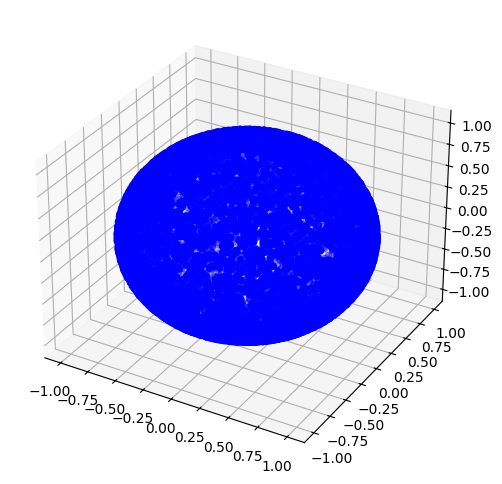

In [31]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
x, y, z = pde_pts[:,0], pde_pts[:,1], pde_pts[:,2]
scatter = ax.scatter(x, y, z, color='blue')
plt.show()

In [32]:
# plot_vector_field_3d_lines_tf(pde_pts[:,0:3], vel_field, normalVector)

In [33]:
print(pde_pts.shape)
print(ic_pts[1][0].shape)

(10000, 4)
(10000, 1)


In [34]:
def normalVector(xyz, knn=30):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    # Use a k-NN search to estimate normals
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamKNN(knn=knn)
    )
    # (Optional) consistently orient normals
    pcd.orient_normals_towards_camera_location(pcd.get_center())
    normals = np.asarray(pcd.normals, dtype=np.float32)
    return normals / np.linalg.norm(normals, axis=1, keepdims=True)

In [35]:
def compute_normal_jacobian(xyz, normals, k=200, h=0.5):
    """
    xyz: (N,3)
    normals: (N,3)
    k: number of neighbors
    h: length‐scale for Gaussian weighting
    returns: (N,3,3)
    """
    N = xyz.shape[0]
    jac = np.zeros((N, 3, 3), dtype=np.float32)

    nbrs = NearestNeighbors(n_neighbors=k+1).fit(xyz)
    distances, indices = nbrs.kneighbors(xyz)

    for i in range(N):
        neigh = indices[i, 1:]
        A = xyz[neigh] - xyz[i]         # (k,3)
        B = normals[neigh] - normals[i] # (k,3)

        # Gaussian weights, shape (k,)
        w = np.exp(- (distances[i,1:]**2) / (h*h))
        # build weighted A and B
        Wsqrt = np.sqrt(w)[:, None]     # (k,1)
        Aw = A * Wsqrt                  # each row scaled
        Bw = B * Wsqrt

        # solve Aw @ J = Bw
        J, *_ = np.linalg.lstsq(Aw, Bw, rcond=None)
        jac[i] = J

    return jac

In [36]:
normals = normalVector(pde_pts[:,0:3])
normal_jacobian = tf.convert_to_tensor(compute_normal_jacobian(pde_pts[:,0:3].numpy(), normals), dtype=tf.float32)

In [37]:
all_pts = tf.concat([pde_pts, ic_pts[0]], axis=0) # use this one for soft constraints
# all_pts = pde_pts # use this one for hard contraint
pmin = tf.reduce_min(all_pts, axis=0)
pmax = tf.reduce_max(all_pts, axis=0)

In [38]:
# This is a special normalize layer for this pde case only
class Normalize(tf.keras.layers.Layer):
  def __init__(self, xmin, xmax, name=None, **kwargs):
    super(Normalize, self).__init__(name=name)
    self.xmin = xmin
    self.xmax = xmax
    super(Normalize, self).__init__(**kwargs)

  def call(self, inputs):
    # if inputs.shape[0] == 2:
    #   constant_part = inputs[0:1:,:,]
    #   other_part = inputs[1:2:,:,]
    #   other_part = 2.0*(other_part-self.xmin[1:2:,:,])/(self.xmax[1:2:,:,]-self.xmin[1:2:,:,])-1.0
    #   return tf.concat([constant_part, other_part], axis=0)
    return 2.0*(inputs-self.xmin)/(self.xmax-self.xmin)-1.0

  def get_config(self):
    config = super(Normalize, self).get_config()
    config.update({'xmin': self.xmin, 'xmax': self.xmax})
    return config

In [39]:
def buildModel(width, depth, pmin, pmax):
  trunk_x = tf.keras.layers.Input(shape=(1,))
  trunk_y = tf.keras.layers.Input(shape=(1,))
  trunk_z = tf.keras.layers.Input(shape=(1,))
  trunk_t = tf.keras.layers.Input(shape=(1,))
  b = tf.keras.layers.Concatenate()([trunk_x, trunk_y, trunk_z, trunk_t])
  
  b = Normalize(pmin, pmax)(b)
  for i in range(depth):
    b = tf.keras.layers.Dense(width, activation='tanh')(b)
  out = tf.keras.layers.Dense(width, activation='tanh')(b)

  out = tf.keras.layers.Dense(2, use_bias=True)(out)

  return tf.keras.Model([trunk_x, trunk_y, trunk_z, trunk_t], out)

In [40]:
# model = buildModel(width, depth, modes)

# x, y, z, t = pde_pts[:,0], pde_pts[:,1], pde_pts[:,2], pde_pts[:,3]
# output = tf.squeeze(model([x, y, z, t]))

# output.shape

In [41]:
def L2Error(u_true, u_pred):
  return tf.norm(u_true - u_pred) / tf.norm(u_true)

In [42]:
# def hardConstraint(model, x, y, z, t, init, tmin=tmin, tmax=tmax):
#     x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
#     nn = model([x, y, z, t])

#     uv0 = init

#     u = uv0 + (t - tmin) / (tmax - tmin) * nn
#     # u = initial(x, y, z, radii) + nn

#     return u

In [43]:
# def hardConstraint(model, x, y, z, t, init, tmin=tmin, tmax=tmax):
#     x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
#     nn = model([x, y, z, t])

#     # uv0 = tf.concat(initial(x,y,z), axis=-1)
#     uv0 = init

#     u = uv0 + (t - tmin) / (tmax - tmin) * nn
#     # u = initial(x, y, z, radii) + nn

#     return u

In [44]:
# def hardConstraint(model, x, y, z, t, step, models, prev_inits, intervals, tmin, tmax):
#     x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
#     nn = model([x, y, z, t])
#     if step == 1:
#         uv0 =  tf.concat(initial(x, y, z), axis=-1)

#     else:
#         # Use previous model directly
#         prev_model = models[step-2]
#         t_boundary = tf.ones_like(x) * tmin  # boundary time
#         prev_nn = prev_model([x, y, z, t_boundary])
        
#         # You'll need to store previous model's time range
#         prev_uv0 = prev_inits[step-2]
#         prev_tmin, prev_tmax = intervals[step-2]
#         uv0 = prev_uv0 + (t_boundary - prev_tmin) / (prev_tmax - prev_tmin) * prev_nn
    
#     u = uv0 + (t - tmin) / (tmax - tmin) * nn
#     return u

In [45]:
def hardConstraint(model, x, y, z, t, step, models, prev_inits, intervals, tmin, tmax):
    x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
    nn = model([x, y, z, t])
    return nn

In [46]:
# output = tf.squeeze(hardConstraint(model, x, y, z, t))

In [47]:
# @tf.function
def trainingStep(model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, lambda_pde=1.0, lambda_ic=1.0, alpha=0.0):
  x, y, z, t = tf.split(pde_pts, 4, axis=1)
  x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)
  xyz = tf.stack([x, y, z], axis=1)

  xi, yi, zi, ti = tf.split(ic_pts[0], 4, axis=1)
  xi, yi, zi, ti = tf.squeeze(xi), tf.squeeze(yi), tf.squeeze(zi), tf.squeeze(ti)
  ui = tf.concat(ic_pts[1], axis=-1)

  with tf.GradientTape() as tape:
    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x, y, z, t])
      net = tf.squeeze(hardConstraint(model, x, y, z, t, step, models, init, intervals, tmin=min_time, tmax=max_time))
      u_pde = net[:,0]
      v_pde = net[:,1]  

      ux, uy, uz, ut = tape2.gradient(u_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

      # uncomment for laplacian
      uxx = tape2.gradient(ux, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uyy = tape2.gradient(uy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uzz = tape2.gradient(uz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

      uxy = tape2.gradient(ux, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uxz = tape2.gradient(ux, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uyz = tape2.gradient(uy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

      vx, vy, vz, vt = tape2.gradient(v_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

      # # uncomment for laplacian
      vxx = tape2.gradient(vx, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vyy = tape2.gradient(vy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vzz = tape2.gradient(vz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

      vxy = tape2.gradient(vx, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vxz = tape2.gradient(vx, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vyz = tape2.gradient(vy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      
    u_grads = tf.stack([ux, uy, uz], axis=1)

    u_laplacians = uxx + uyy + uzz

    u_directional_nu = tf.reduce_sum(normals * u_grads, axis=1) # Directional derivatives of u in direction of the normal

    # uncomment for laplacian
    row0 = tf.stack([uxx, uxy, uxz], axis=1)
    row1 = tf.stack([uxy, uyy, uyz], axis=1) 
    row2 = tf.stack([uxz, uyz, uzz], axis=1) 
    u_hessian = tf.stack([row0, row1, row2], axis=1)

    u_directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(u_hessian, tf.expand_dims(normals, axis=-1))), axis=1)

    u_surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))
    
    # surface_grads = grads - normals * tf.expand_dims(directional_nu, axis=-1)

    u_surface_laplacians = u_laplacians - u_surface_hess * u_directional_nu - u_directional_nu_second

    v_grads = tf.stack([vx, vy, vz], axis=1)

    v_laplacians = vxx + vyy + vzz

    v_directional_nu = tf.reduce_sum(normals * v_grads, axis=1) # Directional derivatives of v in direction of the normal

    # uncomment for laplacian
    row0 = tf.stack([vxx, vxy, vxz], axis=1)
    row1 = tf.stack([vxy, vyy, vyz], axis=1) 
    row2 = tf.stack([vxz, vyz, vzz], axis=1) 
    v_hessian = tf.stack([row0, row1, row2], axis=1)

    v_directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(v_hessian, tf.expand_dims(normals, axis=-1))), axis=1)

    v_surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))

    v_surface_laplacians = v_laplacians - v_surface_hess * v_directional_nu - v_directional_nu_second

    eps = 0.01
    a = 0.5
    beta = 0.8
    vega = 0.0001
    alpha = 1000.0
    
    eqn1 = (1 / alpha) * ut - ( (a - u_pde) * (u_pde - 1.0) * u_pde - v_pde + vega * u_surface_laplacians)
    eqn2 = (1 / alpha) * vt - eps * (beta * u_pde - v_pde)
    # eqn1 = ut - u_surface_laplacians
    # eqn2 = vt - v_surface_laplacians

    pde_loss = tf.reduce_mean(eqn1**2) + tf.reduce_mean(eqn2**2)

    u_init_pred = hardConstraint(model, xi, yi, zi, ti, step, models, init, intervals, tmin=min_time, tmax=max_time)

    ic_loss = tf.reduce_mean((u_init_pred - ui)**2)

    loss = lambda_pde * pde_loss + lambda_ic * ic_loss

  grads = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss, pde_loss, ic_loss, grads, u_pde, v_pde

In [48]:
def final_hard_constraint(model, x, y, z, t, tmin=tmin, tmax=tmax):
    x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
    nn = model([x, y, z, t])

    uv0 = tf.concat(initial(x,y,z), axis=-1)

    u = uv0 + (t - tmin) / (tmax - tmin) * nn
    # u = initial(x, y, z, radii) + nn

    return nn

In [49]:
@tf.function
def final_training_step(model, optimizer, pde_pts, ic_pts, data, init, min_time, max_time, normals, normal_jacobian, lambda_pde=1.0, lambda_ic=1.0, lambda_d=1.0):
  x, y, z, t = tf.split(pde_pts, 4, axis=1)
  x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)
  xyz = tf.stack([x, y, z], axis=1)

  xi, yi, zi, ti = tf.split(ic_pts[0], 4, axis=1)
  xi, yi, zi, ti = tf.squeeze(xi), tf.squeeze(yi), tf.squeeze(zi), tf.squeeze(ti)
  ui = tf.concat(ic_pts[1], axis=-1)

  with tf.GradientTape() as tape:
    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x, y, z, t])

      net = tf.squeeze(final_hard_constraint(model, x, y, z, t, min_time, max_time))

      u_pde = net[:,0]
      v_pde = net[:,1]  

      ux, uy, uz, ut = tape2.gradient(u_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

      # uncomment for laplacian
      uxx = tape2.gradient(ux, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uyy = tape2.gradient(uy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uzz = tape2.gradient(uz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

      uxy = tape2.gradient(ux, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uxz = tape2.gradient(ux, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uyz = tape2.gradient(uy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

      vx, vy, vz, vt = tape2.gradient(v_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

      # # uncomment for laplacian
      vxx = tape2.gradient(vx, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vyy = tape2.gradient(vy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vzz = tape2.gradient(vz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

      vxy = tape2.gradient(vx, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vxz = tape2.gradient(vx, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vyz = tape2.gradient(vy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      
    u_grads = tf.stack([ux, uy, uz], axis=1)

    u_laplacians = uxx + uyy + uzz

    u_directional_nu = tf.reduce_sum(normals * u_grads, axis=1) # Directional derivatives of u in direction of the normal

    # uncomment for laplacian
    row0 = tf.stack([uxx, uxy, uxz], axis=1)
    row1 = tf.stack([uxy, uyy, uyz], axis=1) 
    row2 = tf.stack([uxz, uyz, uzz], axis=1) 
    u_hessian = tf.stack([row0, row1, row2], axis=1)

    u_directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(u_hessian, tf.expand_dims(normals, axis=-1))), axis=1)

    u_surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))
    
    # surface_grads = grads - normals * tf.expand_dims(directional_nu, axis=-1)

    u_surface_laplacians = u_laplacians - u_surface_hess * u_directional_nu - u_directional_nu_second

    v_grads = tf.stack([vx, vy, vz], axis=1)

    v_laplacians = vxx + vyy + vzz

    v_directional_nu = tf.reduce_sum(normals * v_grads, axis=1) # Directional derivatives of v in direction of the normal

    # uncomment for laplacian
    row0 = tf.stack([vxx, vxy, vxz], axis=1)
    row1 = tf.stack([vxy, vyy, vyz], axis=1) 
    row2 = tf.stack([vxz, vyz, vzz], axis=1) 
    v_hessian = tf.stack([row0, row1, row2], axis=1)

    v_directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(v_hessian, tf.expand_dims(normals, axis=-1))), axis=1)

    v_surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))

    v_surface_laplacians = v_laplacians - v_surface_hess * v_directional_nu - v_directional_nu_second

    eps = 0.01
    a = 0.5
    beta = 0.8
    vega = 0.0001
    alpha = 1000.0
    
    eqn1 = (1 / alpha) * ut - ( (a - u_pde) * (u_pde - 1.0) * u_pde - v_pde + vega * u_surface_laplacians)
    eqn2 = (1 / alpha) * vt - eps * (beta * u_pde - v_pde)
    # eqn1 = ut - u_surface_laplacians
    # eqn2 = vt - v_surface_laplacians

    pde_loss = tf.reduce_mean(eqn1**2) + tf.reduce_mean(eqn2**2)

    u_init_pred = tf.squeeze(final_hard_constraint(model, xi, yi, zi, ti, min_time, max_time))

    ic_loss = tf.reduce_mean((u_init_pred - ui)**2)
    # ic_loss = 0.0

    data_loss = tf.reduce_mean((net - data)**2)

    loss = lambda_pde * pde_loss + lambda_ic * ic_loss +  lambda_d * data_loss

  grads = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss, pde_loss, ic_loss, grads, u_pde, v_pde

In [50]:
def train(ts, model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, final=False, data=None, epochs=1000):
  losses = []
  pde_losses = []
  ic_losses = []
  l2s = []
  uv2 = []

  batch_size = 256

  # dataset = (
  # tf.data.Dataset.from_tensor_slices((pde_pts, ic_pts, init, normals, normal_jacobian))
  # .shuffle(N_inputs)
  # .batch(batch_size)
  # .prefetch(tf.data.AUTOTUNE)
  #           )

  ran_lbfgs = False

  # for epoch in range(epochs):   
  #   avg_loss = 0.0
  #   for pde_batch, ic_batch, radii_batch, u_sensor_batch, normals_batch, normal_jac_batch in dataset:
  #     if epoch < epochs // 2:
  #       loss, pde_loss, ic_loss, grads, u_pred = trainingStep(model, optimizer, pde_batch, ic_batch, u_sensor_batch, radii_batch, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0) 
  #       avg_loss += loss  
  #       # losses.append(loss)
  #       # pde_losses.append(pde_loss)
  #       # ic_losses.append(ic_loss)
  #     else:
  #       loss, pde_loss, ic_loss, grads, u_pred = trainingStep(model, optimizer, pde_batch, ic_batch, u_sensor_batch, radii_batch, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0)   
  #       avg_loss += loss
  #       # losses.append(loss)
  #       # pde_losses.append(pde_loss)
  #       # ic_losses.append(ic_loss)
  #   losses.append(avg_loss / batch_size)

  for epoch in range(epochs):
    avg_loss = 0.0
    # for pde_batch, ic_batch, radii_batch, u_sensor_batch, v_sensor_batch, normals_batch, normal_jac_batch in dataset:
    #   loss, pde_loss, ic_loss, grads, u_pred, v_pred = trainingStep(model, optimizer, pde_batch, ic_batch, u_sensor_batch, v_sensor_batch, radii_batch, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0)   
      # avg_loss += loss
    if not final:
      loss, pde_loss, ic_loss, grads, u_pred, v_pred = ts(model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0)    
    else:
      loss, pde_loss, ic_loss, grads, u_pred, v_pred = ts(model, optimizer, pde_pts, ic_pts, data, init, min_time, max_time, normals, normal_jacobian, lambda_ic=1.0, lambda_pde=1.0, lambda_d=1.0)    
    # losses.append(avg_loss / batch_size)
    losses.append(loss)

    if epoch % 100 == 0:
      print(f"Epoch {epoch} - PDE Loss {pde_loss: .6f} - IC Loss {ic_loss: .6f} - Total Loss {loss: .6f}")
      print("mean u:", tf.reduce_mean(u_pred).numpy())
      # print("std u:", tf.math.reduce_std(u_pred).numpy())
      print("mean v:", tf.reduce_mean(v_pred).numpy())
      # print("std v:", tf.math.reduce_std(v_pred).numpy())
      print("uv^2:", tf.reduce_mean(u_pred * v_pred ** 2).numpy())
      # for g in grads:
      #     tf.print("grad mean:", tf.reduce_mean(tf.abs(g)))
      #     tf.print("grad max:", tf.reduce_max(tf.abs(g)))
      uv2.append(tf.reduce_mean(u_pred * v_pred ** 2).numpy())
  
  return losses, pde_losses, ic_losses, l2s, grads, uv2

In [51]:
# model = buildModel(width, depth, modes)

In [52]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=5000,
    decay_rate=0.5)

In [53]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [54]:
# model.save_weights('fh209.weights.h5')

In [55]:
def build_init(steps, models, x, y, z, intervals):
    """
    Pre-build the chain of initial conditions in a differentiable way
    """
    init_conditions = []
    
    # First condition
    first_init = tf.concat(initial(x, y, z), axis=-1)
    init_conditions.append(first_init)
    
    # Build subsequent conditions
    for i in range(1, steps):
        prev_model = models[i-1]
        prev_tmin, prev_tmax = intervals[i-1]
        curr_tmin, curr_tmax = intervals[i]

        # Boundary time (end of previous interval)
        t_boundary = tf.ones_like(x) * curr_tmin
        
        # Get previous model's prediction at boundary
        prev_nn = prev_model([x, y, z, t_boundary])
        prev_uv0 = init_conditions[i-1]
        
        # Compute boundary value using previous model's hard constraint
        boundary_value = prev_nn
        init_conditions.append(boundary_value)
    
    return init_conditions

In [56]:
def prediction(x, y, z, t,  models, intervals):
    preds = []
    out_shape = tf.shape(x)
    out_dim = 2
    preds = tf.zeros([out_shape[0], out_dim], dtype=tf.float32)
    for j in range(len(models)):
        min_t = intervals[j][0]
        max_t = intervals[j][1]
        mask = tf.where((t >= min_t) & (t <= max_t), True, False)
        indices_j = tf.where(mask)[:, 0]
        xj, yj, zj, tj = tf.boolean_mask(x, mask, axis=0), tf.boolean_mask(y, mask, axis=0), tf.boolean_mask(z, mask, axis=0), tf.boolean_mask(t, mask, axis=0)
        xj, yj, zj, tj = tf.reshape(xj, [-1, 1]), tf.reshape(yj, [-1, 1]), tf.reshape(zj, [-1, 1]), tf.reshape(tj, [-1, 1])
        intervals_j = intervals[:j+1]
        mj = models[j]

        inits_j = build_init(j+1, models[:j], xj, yj, zj, intervals_j)
        # print(models[:j])

        mi_pred = mj([xj, yj, zj, tj])
        # preds.append(mi_pred)
        preds = tf.tensor_scatter_nd_update(
            preds, tf.expand_dims(indices_j, axis=1), mi_pred
        )

    return preds

max time: 0.01, min_time 0.0
Epoch 0 - PDE Loss  0.030340 - IC Loss  1.089571 - Total Loss  1.119912
mean u: 0.003440699
mean v: 0.0006025355
uv^2: 2.2211596e-05
Epoch 100 - PDE Loss  0.050525 - IC Loss  0.699200 - Total Loss  0.749724
mean u: 0.42696562
mean v: -0.07150344
uv^2: 0.011265948
Epoch 200 - PDE Loss  0.075343 - IC Loss  0.492003 - Total Loss  0.567346
mean u: 0.3780102
mean v: -0.02545969
uv^2: -0.01220792
Epoch 300 - PDE Loss  0.064524 - IC Loss  0.310365 - Total Loss  0.374889
mean u: 0.47603014
mean v: 0.007564215
uv^2: -0.0082683135
Epoch 400 - PDE Loss  0.063108 - IC Loss  0.205337 - Total Loss  0.268445
mean u: 0.49470738
mean v: -0.028451813
uv^2: 0.005252809


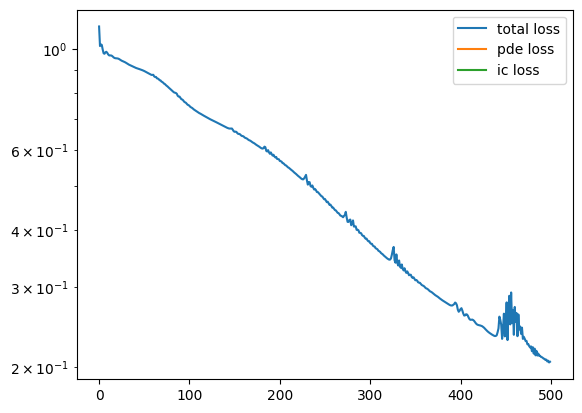

max time: 0.02, min_time 0.01
Epoch 0 - PDE Loss  0.088381 - IC Loss  0.166981 - Total Loss  0.255362
mean u: -0.0005928063
mean v: -0.0005257466
uv^2: -0.0002516432
Epoch 100 - PDE Loss  0.002184 - IC Loss  0.015093 - Total Loss  0.017277
mean u: 0.5248841
mean v: 0.0059552914
uv^2: 0.0011733305
Epoch 200 - PDE Loss  0.001129 - IC Loss  0.008065 - Total Loss  0.009194
mean u: 0.4287927
mean v: 0.012729486
uv^2: 0.0014696491
Epoch 300 - PDE Loss  0.001111 - IC Loss  0.004115 - Total Loss  0.005226
mean u: 0.45711547
mean v: 0.010043902
uv^2: 0.001323329
Epoch 400 - PDE Loss  0.001125 - IC Loss  0.002108 - Total Loss  0.003233
mean u: 0.49447817
mean v: 0.0076323953
uv^2: 0.0012889998


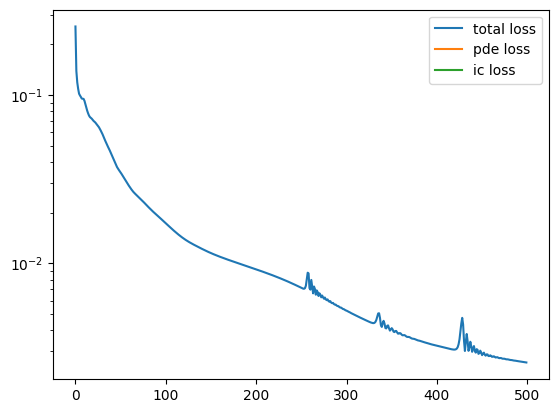

max time: 0.03, min_time 0.02
Epoch 0 - PDE Loss  0.034748 - IC Loss  0.163231 - Total Loss  0.197980
mean u: 0.0008685045
mean v: 0.00022278109
uv^2: -4.4709263e-06
Epoch 100 - PDE Loss  0.000765 - IC Loss  0.014541 - Total Loss  0.015306
mean u: 0.5179578
mean v: 0.0002966432
uv^2: 0.00059275894
Epoch 200 - PDE Loss  0.000448 - IC Loss  0.006229 - Total Loss  0.006677
mean u: 0.4838994
mean v: -0.0014397224
uv^2: 0.0010492983
Epoch 300 - PDE Loss  0.000360 - IC Loss  0.003812 - Total Loss  0.004172
mean u: 0.47986835
mean v: -0.00056672614
uv^2: 0.0010689964
Epoch 400 - PDE Loss  0.000360 - IC Loss  0.002725 - Total Loss  0.003086
mean u: 0.48043355
mean v: -0.00076595834
uv^2: 0.0010380568


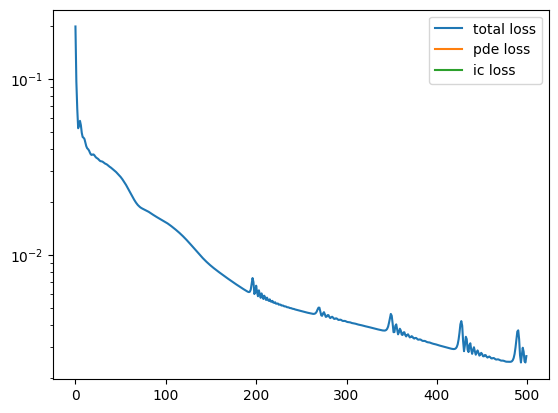

max time: 0.04, min_time 0.03
Epoch 0 - PDE Loss  0.060538 - IC Loss  0.212707 - Total Loss  0.273244
mean u: 0.000110200024
mean v: 0.0007740416
uv^2: 7.082446e-05
Epoch 100 - PDE Loss  0.000245 - IC Loss  0.014367 - Total Loss  0.014612
mean u: 0.4141538
mean v: -0.0017156323
uv^2: 0.00025336986
Epoch 200 - PDE Loss  0.000480 - IC Loss  0.004692 - Total Loss  0.005172
mean u: 0.46192157
mean v: -0.0029646037
uv^2: 0.00036336307
Epoch 300 - PDE Loss  0.000404 - IC Loss  0.000822 - Total Loss  0.001226
mean u: 0.49369806
mean v: -0.0027432526
uv^2: 0.0003945786
Epoch 400 - PDE Loss  0.000348 - IC Loss  0.000544 - Total Loss  0.000892
mean u: 0.4959739
mean v: -0.0027765995
uv^2: 0.00040957026


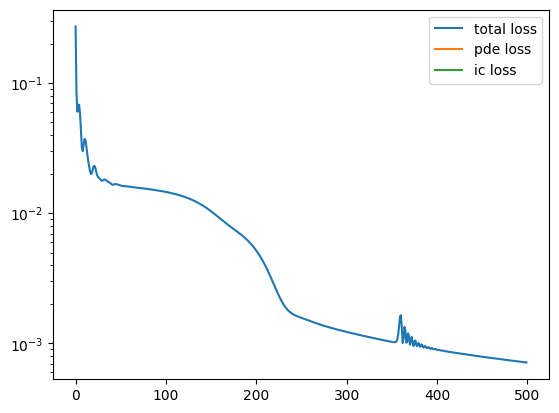

max time: 0.05, min_time 0.04
Epoch 0 - PDE Loss  0.084296 - IC Loss  0.131836 - Total Loss  0.216132
mean u: 0.0026500854
mean v: 0.0026730204
uv^2: 6.38751e-05
Epoch 100 - PDE Loss  0.000429 - IC Loss  0.005068 - Total Loss  0.005497
mean u: 0.40897247
mean v: 0.0073977495
uv^2: 0.0004560849
Epoch 200 - PDE Loss  0.000332 - IC Loss  0.000452 - Total Loss  0.000784
mean u: 0.50130063
mean v: 0.002735474
uv^2: 0.00061387074
Epoch 300 - PDE Loss  0.000255 - IC Loss  0.000266 - Total Loss  0.000521
mean u: 0.49748036
mean v: 0.0023867367
uv^2: 0.0005422602
Epoch 400 - PDE Loss  0.000220 - IC Loss  0.000177 - Total Loss  0.000397
mean u: 0.49907398
mean v: 0.0019081396
uv^2: 0.0005044448


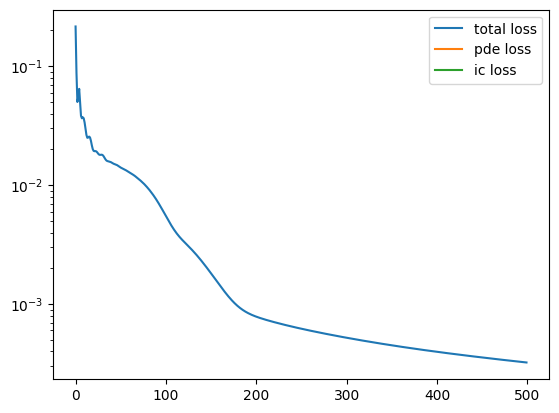

max time: 0.06, min_time 0.05
Epoch 0 - PDE Loss  0.094967 - IC Loss  0.268049 - Total Loss  0.363016
mean u: 0.0001005538
mean v: 1.3863563e-06
uv^2: -6.538853e-05
Epoch 100 - PDE Loss  0.000145 - IC Loss  0.011299 - Total Loss  0.011443
mean u: 0.37831375
mean v: 0.00069769495
uv^2: 0.00015406017
Epoch 200 - PDE Loss  0.000155 - IC Loss  0.006601 - Total Loss  0.006757
mean u: 0.42435917
mean v: -0.002180775
uv^2: 0.0003320344
Epoch 300 - PDE Loss  0.000289 - IC Loss  0.001314 - Total Loss  0.001603
mean u: 0.47388822
mean v: 0.00022370086
uv^2: 0.0005467905
Epoch 400 - PDE Loss  0.000188 - IC Loss  0.000292 - Total Loss  0.000480
mean u: 0.4778788
mean v: -0.00044009162
uv^2: 0.0005359887


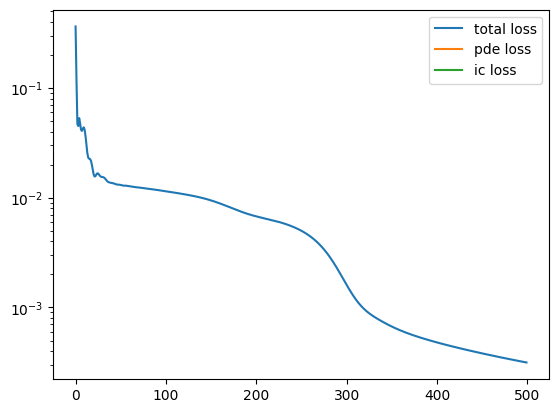

max time: 0.07, min_time 0.06
Epoch 0 - PDE Loss  0.059991 - IC Loss  0.265148 - Total Loss  0.325138
mean u: -0.0020538694
mean v: 0.0032336402
uv^2: -0.00030333875
Epoch 100 - PDE Loss  0.000076 - IC Loss  0.011569 - Total Loss  0.011644
mean u: 0.3812301
mean v: -0.0010918252
uv^2: 0.0001600738
Epoch 200 - PDE Loss  0.000172 - IC Loss  0.006396 - Total Loss  0.006568
mean u: 0.45431596
mean v: -0.0018839478
uv^2: 0.00040866222
Epoch 300 - PDE Loss  0.000190 - IC Loss  0.000528 - Total Loss  0.000718
mean u: 0.49526748
mean v: -0.0026379365
uv^2: 0.0004919041
Epoch 400 - PDE Loss  0.000133 - IC Loss  0.000268 - Total Loss  0.000402
mean u: 0.49446133
mean v: -0.0027721263
uv^2: 0.0004976344


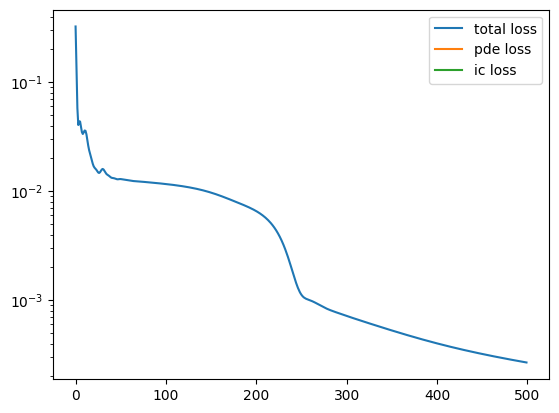

max time: 0.08, min_time 0.07
Epoch 0 - PDE Loss  0.054882 - IC Loss  0.201098 - Total Loss  0.255979
mean u: 0.0010724466
mean v: -0.0038713638
uv^2: 0.00012024862
Epoch 100 - PDE Loss  0.000193 - IC Loss  0.007222 - Total Loss  0.007414
mean u: 0.4167937
mean v: 0.001224055
uv^2: 0.00026188607
Epoch 200 - PDE Loss  0.000145 - IC Loss  0.000274 - Total Loss  0.000419
mean u: 0.48417643
mean v: 0.0016503363
uv^2: 0.0005340697
Epoch 300 - PDE Loss  0.000095 - IC Loss  0.000109 - Total Loss  0.000204
mean u: 0.5157456
mean v: 0.00084640406
uv^2: 0.00056668627
Epoch 400 - PDE Loss  0.000086 - IC Loss  0.000062 - Total Loss  0.000147
mean u: 0.5165228
mean v: 0.0009276656
uv^2: 0.0005728321


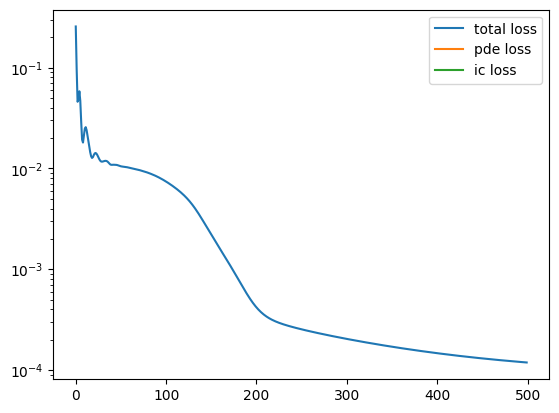

max time: 0.09, min_time 0.08
Epoch 0 - PDE Loss  0.013751 - IC Loss  0.159590 - Total Loss  0.173340
mean u: -0.001078405
mean v: -0.0014645319
uv^2: -2.4537647e-05
Epoch 100 - PDE Loss  0.000333 - IC Loss  0.007042 - Total Loss  0.007375
mean u: 0.38760397
mean v: 0.00672873
uv^2: 0.0003657757
Epoch 200 - PDE Loss  0.000094 - IC Loss  0.000309 - Total Loss  0.000403
mean u: 0.52691084
mean v: 0.0056955824
uv^2: 0.00063481915
Epoch 300 - PDE Loss  0.000080 - IC Loss  0.000040 - Total Loss  0.000120
mean u: 0.5240746
mean v: 0.0059386827
uv^2: 0.0006481977
Epoch 400 - PDE Loss  0.000076 - IC Loss  0.000031 - Total Loss  0.000107
mean u: 0.5260266
mean v: 0.0057423157
uv^2: 0.00064859993


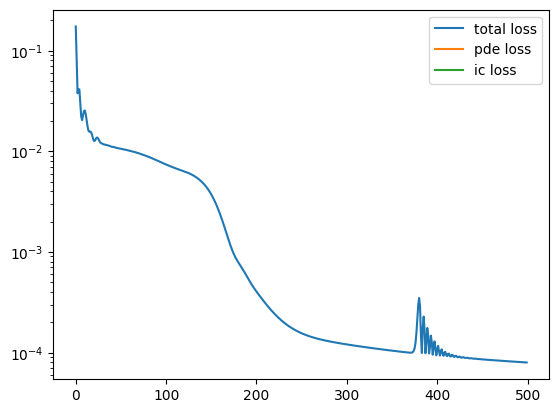

max time: 0.1, min_time 0.09
Epoch 0 - PDE Loss  0.054666 - IC Loss  0.356292 - Total Loss  0.410957
mean u: -0.0022168674
mean v: 0.0042882888
uv^2: -0.00030350333
Epoch 100 - PDE Loss  0.000265 - IC Loss  0.005864 - Total Loss  0.006129
mean u: 0.35232946
mean v: 0.0070907827
uv^2: 0.00015713405
Epoch 200 - PDE Loss  0.000212 - IC Loss  0.000748 - Total Loss  0.000960
mean u: 0.4262482
mean v: 0.006472646
uv^2: 0.00043405543
Epoch 300 - PDE Loss  0.000099 - IC Loss  0.000141 - Total Loss  0.000240
mean u: 0.49919415
mean v: 0.004962403
uv^2: 0.00059593294
Epoch 400 - PDE Loss  0.000084 - IC Loss  0.000086 - Total Loss  0.000170
mean u: 0.508516
mean v: 0.0048190253
uv^2: 0.00060255773


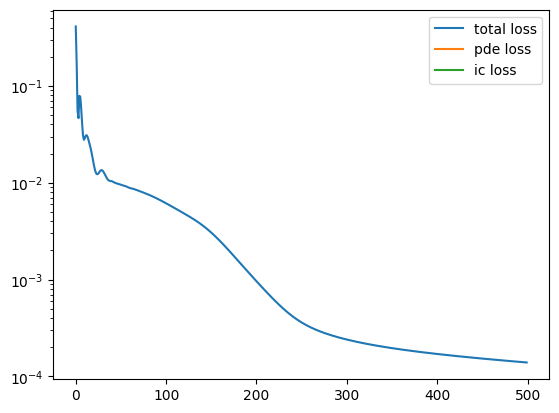

max time: 0.11, min_time 0.1
Epoch 0 - PDE Loss  0.056023 - IC Loss  0.051092 - Total Loss  0.107116
mean u: 0.0038897484
mean v: -0.0038551106
uv^2: 0.0005582248
Epoch 100 - PDE Loss  0.000055 - IC Loss  0.008562 - Total Loss  0.008616
mean u: 0.424401
mean v: 0.0025693404
uv^2: 0.000224368
Epoch 200 - PDE Loss  0.000128 - IC Loss  0.000814 - Total Loss  0.000941
mean u: 0.4841206
mean v: 0.003951012
uv^2: 0.0005415052
Epoch 300 - PDE Loss  0.000106 - IC Loss  0.000135 - Total Loss  0.000241
mean u: 0.489529
mean v: 0.0033630729
uv^2: 0.0005362825
Epoch 400 - PDE Loss  0.000081 - IC Loss  0.000059 - Total Loss  0.000140
mean u: 0.49446425
mean v: 0.0033445633
uv^2: 0.00054333097


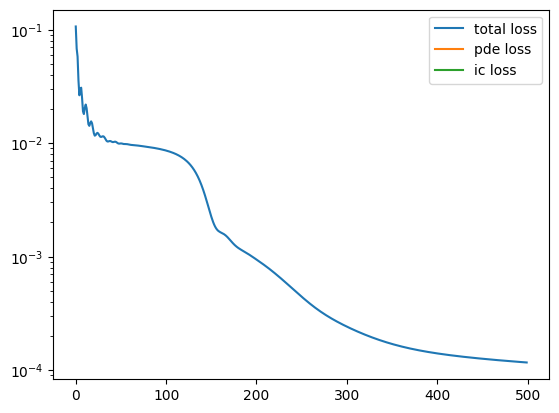

max time: 0.12, min_time 0.11
Epoch 0 - PDE Loss  0.030144 - IC Loss  0.033340 - Total Loss  0.063485
mean u: 0.00072776974
mean v: -0.0026663286
uv^2: 6.1930485e-05
Epoch 100 - PDE Loss  0.000172 - IC Loss  0.001080 - Total Loss  0.001252
mean u: 0.44494537
mean v: 0.0017182716
uv^2: 0.0004369563
Epoch 200 - PDE Loss  0.000084 - IC Loss  0.000040 - Total Loss  0.000124
mean u: 0.4777213
mean v: -2.8202521e-05
uv^2: 0.0004914615
Epoch 300 - PDE Loss  0.000067 - IC Loss  0.000019 - Total Loss  0.000086
mean u: 0.4799061
mean v: -0.00033239485
uv^2: 0.00049463223
Epoch 400 - PDE Loss  0.000115 - IC Loss  0.000036 - Total Loss  0.000152
mean u: 0.4810398
mean v: -0.0002729237
uv^2: 0.0005158382


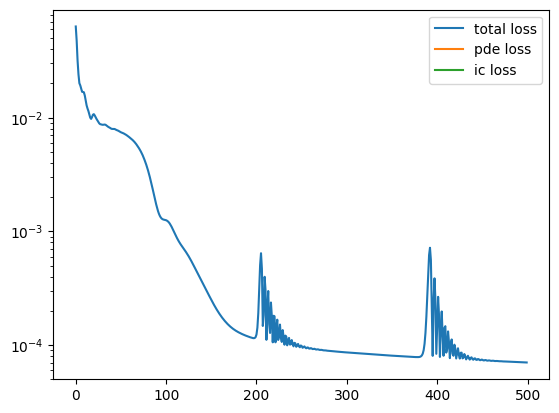

max time: 0.13, min_time 0.12
Epoch 0 - PDE Loss  0.067953 - IC Loss  0.134319 - Total Loss  0.202272
mean u: 0.001312929
mean v: -0.00012292895
uv^2: -3.999453e-05
Epoch 100 - PDE Loss  0.000094 - IC Loss  0.007664 - Total Loss  0.007759
mean u: 0.37018546
mean v: 0.0020916236
uv^2: 0.00015575811
Epoch 200 - PDE Loss  0.000164 - IC Loss  0.000947 - Total Loss  0.001111
mean u: 0.47691768
mean v: -0.00086253794
uv^2: 0.00046519656
Epoch 300 - PDE Loss  0.000094 - IC Loss  0.000206 - Total Loss  0.000300
mean u: 0.46821994
mean v: -0.0019880158
uv^2: 0.0004621358
Epoch 400 - PDE Loss  0.000074 - IC Loss  0.000047 - Total Loss  0.000121
mean u: 0.46318227
mean v: -0.0027047761
uv^2: 0.00044968558


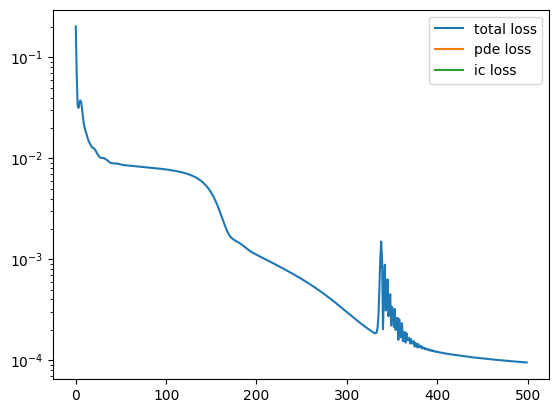

max time: 0.14, min_time 0.13
Epoch 0 - PDE Loss  0.053252 - IC Loss  0.227261 - Total Loss  0.280513
mean u: -0.0012972094
mean v: -0.001478866
uv^2: -2.7317847e-05
Epoch 100 - PDE Loss  0.000168 - IC Loss  0.006194 - Total Loss  0.006362
mean u: 0.37841806
mean v: -0.0056732083
uv^2: 0.0001775599
Epoch 200 - PDE Loss  0.000208 - IC Loss  0.000645 - Total Loss  0.000853
mean u: 0.38498932
mean v: -0.004485282
uv^2: 0.00025604712
Epoch 300 - PDE Loss  0.000081 - IC Loss  0.000070 - Total Loss  0.000150
mean u: 0.4358045
mean v: -0.0062990873
uv^2: 0.00036811543
Epoch 400 - PDE Loss  0.000069 - IC Loss  0.000043 - Total Loss  0.000111
mean u: 0.44536567
mean v: -0.00663834
uv^2: 0.00039256338


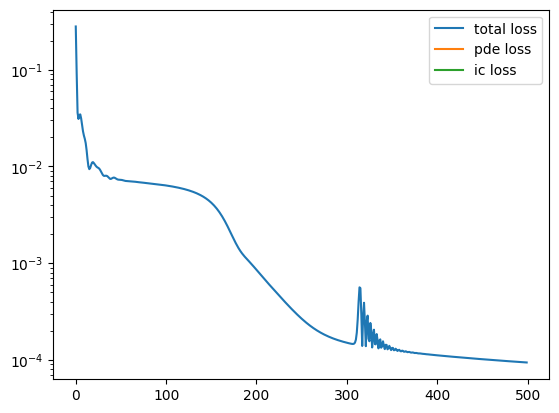

max time: 0.15, min_time 0.14
Epoch 0 - PDE Loss  0.047010 - IC Loss  0.188496 - Total Loss  0.235506
mean u: -0.0006631493
mean v: 0.0019490223
uv^2: -5.541125e-05
Epoch 100 - PDE Loss  0.000131 - IC Loss  0.006419 - Total Loss  0.006550
mean u: 0.34138593
mean v: -0.0072134947
uv^2: 9.605692e-05
Epoch 200 - PDE Loss  0.000074 - IC Loss  0.002409 - Total Loss  0.002484
mean u: 0.40132183
mean v: -0.010594427
uv^2: 0.00023523762
Epoch 300 - PDE Loss  0.000082 - IC Loss  0.000106 - Total Loss  0.000187
mean u: 0.45207676
mean v: -0.008554592
uv^2: 0.0003881897
Epoch 400 - PDE Loss  0.000068 - IC Loss  0.000055 - Total Loss  0.000123
mean u: 0.45778224
mean v: -0.008545741
uv^2: 0.000408587


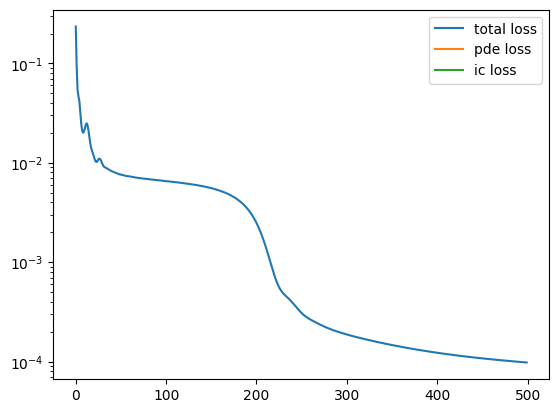

max time: 0.16, min_time 0.15
Epoch 0 - PDE Loss  0.046797 - IC Loss  0.124650 - Total Loss  0.171447
mean u: 0.00086556474
mean v: -0.0011785771
uv^2: 5.3203355e-05
Epoch 100 - PDE Loss  0.000077 - IC Loss  0.005731 - Total Loss  0.005808
mean u: 0.44972953
mean v: -0.0013064356
uv^2: 0.00024141793
Epoch 200 - PDE Loss  0.000172 - IC Loss  0.000813 - Total Loss  0.000985
mean u: 0.46594435
mean v: -0.0030668976
uv^2: 0.00045497494
Epoch 300 - PDE Loss  0.000067 - IC Loss  0.000128 - Total Loss  0.000195
mean u: 0.49573076
mean v: -0.0029407765
uv^2: 0.00046264744
Epoch 400 - PDE Loss  0.000050 - IC Loss  0.000041 - Total Loss  0.000091
mean u: 0.4979837
mean v: -0.0029645718
uv^2: 0.0004648832


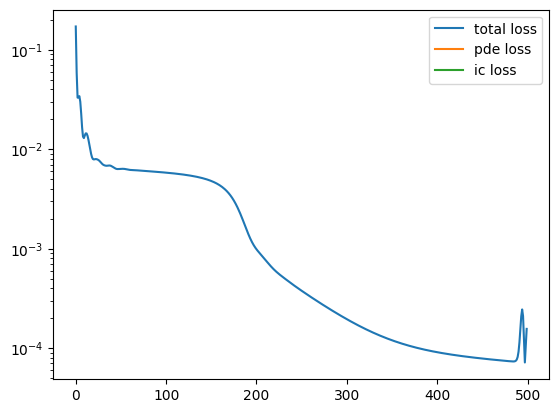

max time: 0.17, min_time 0.16
Epoch 0 - PDE Loss  0.203864 - IC Loss  0.109564 - Total Loss  0.313428
mean u: -0.0046353815
mean v: -0.004373877
uv^2: -0.0008051481
Epoch 100 - PDE Loss  0.000183 - IC Loss  0.005153 - Total Loss  0.005335
mean u: 0.3837964
mean v: 0.0025452042
uv^2: 0.00013212224
Epoch 200 - PDE Loss  0.000127 - IC Loss  0.000781 - Total Loss  0.000908
mean u: 0.47165477
mean v: 0.0034002839
uv^2: 0.00041788744
Epoch 300 - PDE Loss  0.000079 - IC Loss  0.000324 - Total Loss  0.000403
mean u: 0.5081167
mean v: 0.003772065
uv^2: 0.0004607263
Epoch 400 - PDE Loss  0.000059 - IC Loss  0.000129 - Total Loss  0.000188
mean u: 0.50925416
mean v: 0.0035503479
uv^2: 0.00046643542


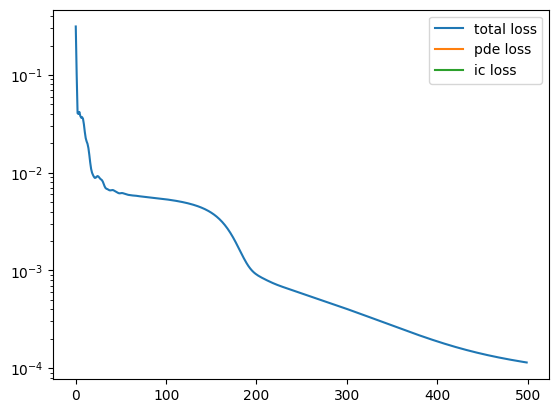

max time: 0.18, min_time 0.17
Epoch 0 - PDE Loss  0.087861 - IC Loss  0.100470 - Total Loss  0.188331
mean u: 0.002367076
mean v: 0.0013118208
uv^2: 0.00015962508
Epoch 100 - PDE Loss  0.000156 - IC Loss  0.004263 - Total Loss  0.004420
mean u: 0.37317738
mean v: 0.004520818
uv^2: 0.00017226847
Epoch 200 - PDE Loss  0.000144 - IC Loss  0.000647 - Total Loss  0.000790
mean u: 0.45321083
mean v: 0.004313315
uv^2: 0.00035339876
Epoch 300 - PDE Loss  0.000086 - IC Loss  0.000370 - Total Loss  0.000456
mean u: 0.4772797
mean v: 0.002817723
uv^2: 0.00038021387
Epoch 400 - PDE Loss  0.000065 - IC Loss  0.000158 - Total Loss  0.000223
mean u: 0.4881296
mean v: 0.002293127
uv^2: 0.00039932723


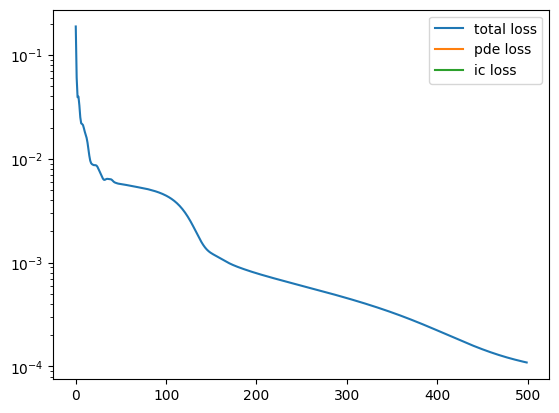

max time: 0.19, min_time 0.18
Epoch 0 - PDE Loss  0.280812 - IC Loss  0.415467 - Total Loss  0.696278
mean u: 0.0009826409
mean v: 0.0009009577
uv^2: 2.0737612e-05
Epoch 100 - PDE Loss  0.000269 - IC Loss  0.004520 - Total Loss  0.004790
mean u: 0.3019374
mean v: 0.0055663316
uv^2: 5.348542e-05
Epoch 200 - PDE Loss  0.000181 - IC Loss  0.002235 - Total Loss  0.002415
mean u: 0.3303306
mean v: 0.0035984109
uv^2: 9.011265e-05
Epoch 300 - PDE Loss  0.000173 - IC Loss  0.000679 - Total Loss  0.000853
mean u: 0.3630817
mean v: 0.00038359765
uv^2: 0.00015253676
Epoch 400 - PDE Loss  0.000121 - IC Loss  0.000292 - Total Loss  0.000413
mean u: 0.40011144
mean v: -0.0018429679
uv^2: 0.00020610656


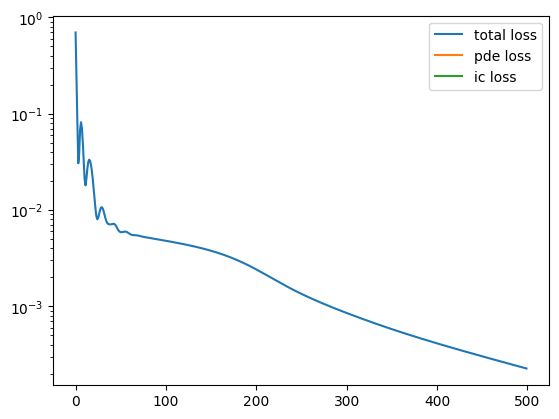

max time: 0.2, min_time 0.19
Epoch 0 - PDE Loss  0.026772 - IC Loss  0.075963 - Total Loss  0.102735
mean u: -0.001159684
mean v: -0.001167278
uv^2: -2.769758e-05
Epoch 100 - PDE Loss  0.000104 - IC Loss  0.002712 - Total Loss  0.002815
mean u: 0.27320945
mean v: -0.012992435
uv^2: 6.338738e-05
Epoch 200 - PDE Loss  0.000142 - IC Loss  0.000139 - Total Loss  0.000280
mean u: 0.33027682
mean v: -0.017920278
uv^2: 0.0001318035
Epoch 300 - PDE Loss  0.000099 - IC Loss  0.000062 - Total Loss  0.000161
mean u: 0.33730146
mean v: -0.019762505
uv^2: 0.00016539817
Epoch 400 - PDE Loss  0.000082 - IC Loss  0.000041 - Total Loss  0.000123
mean u: 0.3380182
mean v: -0.020471955
uv^2: 0.00017731573


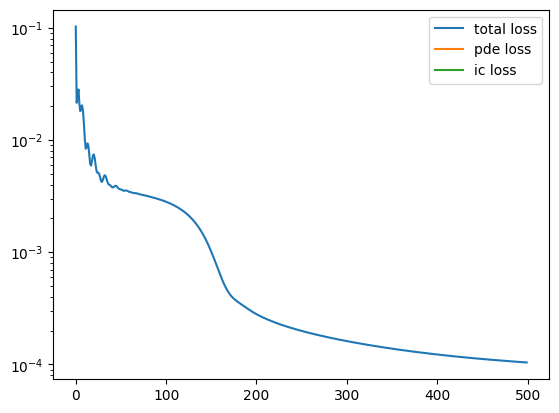

max time: 0.21, min_time 0.2
Epoch 0 - PDE Loss  0.129607 - IC Loss  0.085102 - Total Loss  0.214709
mean u: -0.00069018995
mean v: -0.004741535
uv^2: -8.02521e-05
Epoch 100 - PDE Loss  0.000054 - IC Loss  0.003215 - Total Loss  0.003269
mean u: 0.25762793
mean v: -0.029789224
uv^2: 0.00021842895
Epoch 200 - PDE Loss  0.000035 - IC Loss  0.002852 - Total Loss  0.002887
mean u: 0.24053396
mean v: -0.028301043
uv^2: 0.00018372251
Epoch 300 - PDE Loss  0.000055 - IC Loss  0.001611 - Total Loss  0.001666
mean u: 0.23041387
mean v: -0.027691275
uv^2: 0.0001683515
Epoch 400 - PDE Loss  0.000095 - IC Loss  0.000338 - Total Loss  0.000433
mean u: 0.25643075
mean v: -0.029951759
uv^2: 0.00020769534


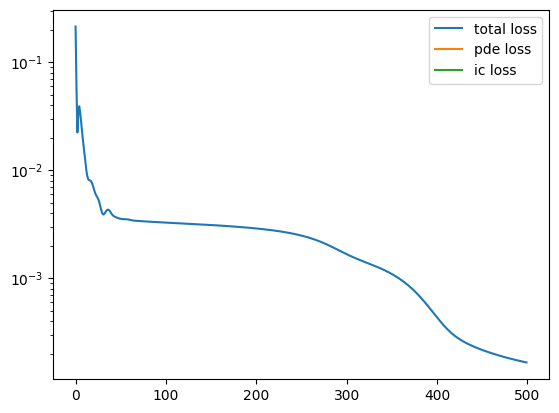

max time: 0.22, min_time 0.21
Epoch 0 - PDE Loss  0.055399 - IC Loss  0.030458 - Total Loss  0.085856
mean u: -0.0020131655
mean v: -0.00070341374
uv^2: 4.5373276e-06
Epoch 100 - PDE Loss  0.000055 - IC Loss  0.002665 - Total Loss  0.002720
mean u: 0.20859197
mean v: -0.03178641
uv^2: 0.0002390144
Epoch 200 - PDE Loss  0.000084 - IC Loss  0.000957 - Total Loss  0.001041
mean u: 0.21626082
mean v: -0.03394624
uv^2: 0.00026102166
Epoch 300 - PDE Loss  0.000087 - IC Loss  0.000062 - Total Loss  0.000149
mean u: 0.2408863
mean v: -0.036712542
uv^2: 0.000318866
Epoch 400 - PDE Loss  0.000072 - IC Loss  0.000037 - Total Loss  0.000109
mean u: 0.24091972
mean v: -0.03727122
uv^2: 0.00032358436


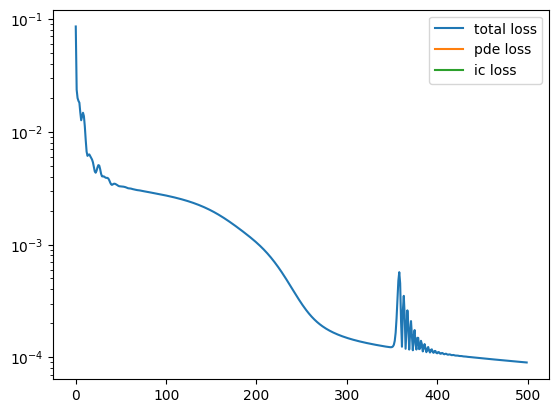

max time: 0.23, min_time 0.22
Epoch 0 - PDE Loss  0.242393 - IC Loss  0.070277 - Total Loss  0.312671
mean u: -0.00078810647
mean v: -0.0014403185
uv^2: -9.085313e-05
Epoch 100 - PDE Loss  0.000044 - IC Loss  0.002777 - Total Loss  0.002821
mean u: 0.24326724
mean v: -0.044847395
uv^2: 0.00048554936
Epoch 200 - PDE Loss  0.000043 - IC Loss  0.002438 - Total Loss  0.002482
mean u: 0.21507588
mean v: -0.041152842
uv^2: 0.00036936512
Epoch 300 - PDE Loss  0.000077 - IC Loss  0.001561 - Total Loss  0.001638
mean u: 0.1954102
mean v: -0.03709335
uv^2: 0.00029163717
Epoch 400 - PDE Loss  0.000065 - IC Loss  0.000289 - Total Loss  0.000354
mean u: 0.20800793
mean v: -0.037692983
uv^2: 0.00031596562


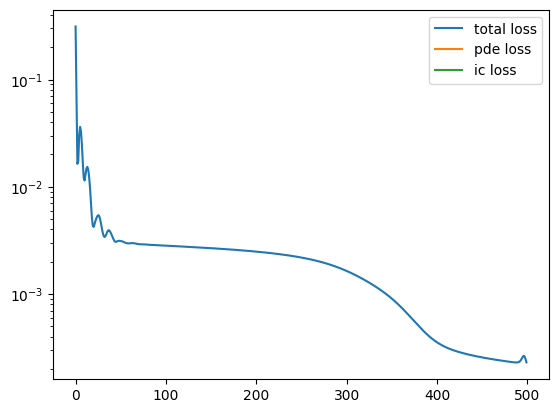

max time: 0.24, min_time 0.23
Epoch 0 - PDE Loss  0.077678 - IC Loss  0.078914 - Total Loss  0.156592
mean u: 0.00078476383
mean v: 0.004320319
uv^2: -0.00016896307
Epoch 100 - PDE Loss  0.000040 - IC Loss  0.002170 - Total Loss  0.002210
mean u: 0.17439802
mean v: -0.03568862
uv^2: 0.00024477587
Epoch 200 - PDE Loss  0.000115 - IC Loss  0.000449 - Total Loss  0.000563
mean u: 0.15294829
mean v: -0.027151324
uv^2: 0.00020075076
Epoch 300 - PDE Loss  0.000063 - IC Loss  0.000094 - Total Loss  0.000157
mean u: 0.18808806
mean v: -0.036386307
uv^2: 0.00028114414
Epoch 400 - PDE Loss  0.000056 - IC Loss  0.000050 - Total Loss  0.000106
mean u: 0.1959489
mean v: -0.038201675
uv^2: 0.00030808424


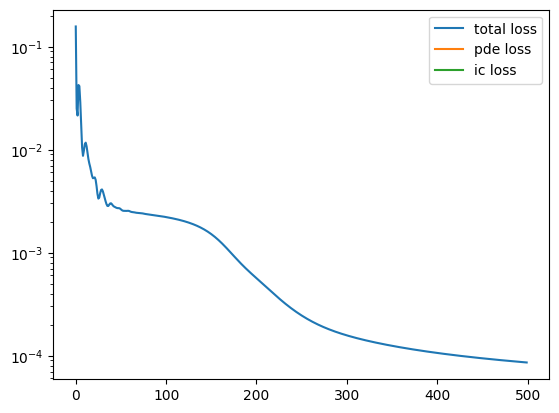

max time: 0.25, min_time 0.24
Epoch 0 - PDE Loss  0.079346 - IC Loss  0.055863 - Total Loss  0.135209
mean u: 0.0005305849
mean v: 0.00025883532
uv^2: 2.1926583e-06
Epoch 100 - PDE Loss  0.000017 - IC Loss  0.002199 - Total Loss  0.002216
mean u: 0.14653738
mean v: -0.033347327
uv^2: 0.00018205961
Epoch 200 - PDE Loss  0.000025 - IC Loss  0.001830 - Total Loss  0.001855
mean u: 0.15368335
mean v: -0.035318676
uv^2: 0.00020741385
Epoch 300 - PDE Loss  0.000065 - IC Loss  0.000371 - Total Loss  0.000436
mean u: 0.17323062
mean v: -0.038190693
uv^2: 0.00028419285
Epoch 400 - PDE Loss  0.000051 - IC Loss  0.000239 - Total Loss  0.000290
mean u: 0.17346296
mean v: -0.038344957
uv^2: 0.00028469012


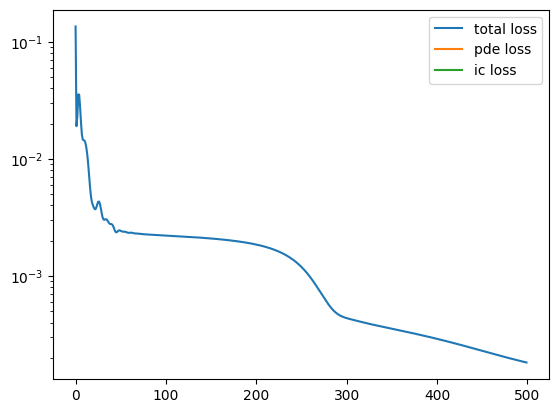

max time: 0.26, min_time 0.25
Epoch 0 - PDE Loss  0.125077 - IC Loss  0.089985 - Total Loss  0.215062
mean u: 0.0017268043
mean v: 0.0040721633
uv^2: 0.00032428565
Epoch 100 - PDE Loss  0.000042 - IC Loss  0.001443 - Total Loss  0.001486
mean u: 0.17655106
mean v: -0.046532378
uv^2: 0.00039376627
Epoch 200 - PDE Loss  0.000060 - IC Loss  0.000189 - Total Loss  0.000249
mean u: 0.15101019
mean v: -0.038207714
uv^2: 0.0002609484
Epoch 300 - PDE Loss  0.000050 - IC Loss  0.000104 - Total Loss  0.000153
mean u: 0.15677531
mean v: -0.03945042
uv^2: 0.00028963745
Epoch 400 - PDE Loss  0.000042 - IC Loss  0.000072 - Total Loss  0.000114
mean u: 0.1557106
mean v: -0.039179977
uv^2: 0.00028409887


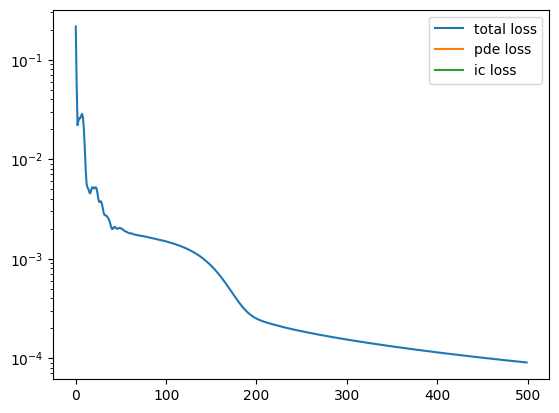

max time: 0.27, min_time 0.26
Epoch 0 - PDE Loss  0.015700 - IC Loss  0.016986 - Total Loss  0.032686
mean u: 0.0029634153
mean v: -0.0017185715
uv^2: 8.619075e-05
Epoch 100 - PDE Loss  0.000056 - IC Loss  0.000802 - Total Loss  0.000858
mean u: 0.14268115
mean v: -0.03920993
uv^2: 0.00024162004
Epoch 200 - PDE Loss  0.000040 - IC Loss  0.000047 - Total Loss  0.000087
mean u: 0.14652222
mean v: -0.03903069
uv^2: 0.00026644903
Epoch 300 - PDE Loss  0.000033 - IC Loss  0.000018 - Total Loss  0.000050
mean u: 0.14583951
mean v: -0.03882464
uv^2: 0.00026387244
Epoch 400 - PDE Loss  0.000030 - IC Loss  0.000014 - Total Loss  0.000044
mean u: 0.14490667
mean v: -0.03863084
uv^2: 0.00026037314


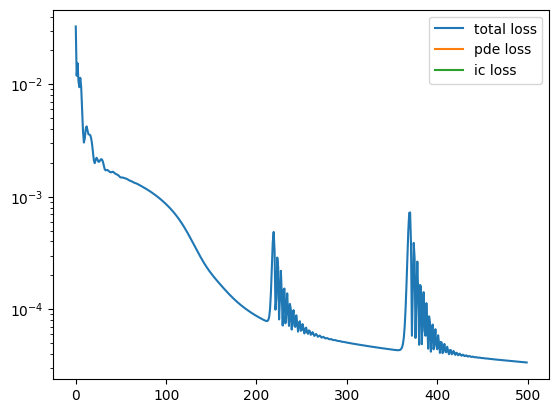

max time: 0.28, min_time 0.27
Epoch 0 - PDE Loss  0.088295 - IC Loss  0.070795 - Total Loss  0.159090
mean u: -0.00095765706
mean v: -0.0041938876
uv^2: -0.00019025822
Epoch 100 - PDE Loss  0.000012 - IC Loss  0.001217 - Total Loss  0.001229
mean u: 0.12200729
mean v: -0.035918664
uv^2: 0.00017125338
Epoch 200 - PDE Loss  0.000015 - IC Loss  0.000816 - Total Loss  0.000831
mean u: 0.121172726
mean v: -0.034830004
uv^2: 0.00016583865
Epoch 300 - PDE Loss  0.000032 - IC Loss  0.000057 - Total Loss  0.000089
mean u: 0.123624764
mean v: -0.03346676
uv^2: 0.00019555262
Epoch 400 - PDE Loss  0.000022 - IC Loss  0.000023 - Total Loss  0.000045
mean u: 0.12701023
mean v: -0.03463952
uv^2: 0.00020419857


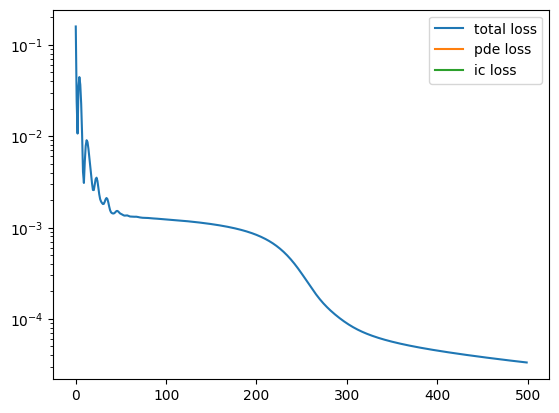

max time: 0.29, min_time 0.28
Epoch 0 - PDE Loss  0.072270 - IC Loss  0.030622 - Total Loss  0.102891
mean u: -0.0019699598
mean v: -0.003277016
uv^2: -0.00014210102
Epoch 100 - PDE Loss  0.000020 - IC Loss  0.001075 - Total Loss  0.001095
mean u: 0.10703528
mean v: -0.033595897
uv^2: 0.00013782596
Epoch 200 - PDE Loss  0.000009 - IC Loss  0.000769 - Total Loss  0.000779
mean u: 0.08770036
mean v: -0.02557754
uv^2: 7.988247e-05
Epoch 300 - PDE Loss  0.000026 - IC Loss  0.000063 - Total Loss  0.000088
mean u: 0.09838374
mean v: -0.02823942
uv^2: 0.00013563911
Epoch 400 - PDE Loss  0.000019 - IC Loss  0.000025 - Total Loss  0.000044
mean u: 0.099869564
mean v: -0.029028652
uv^2: 0.00013905787


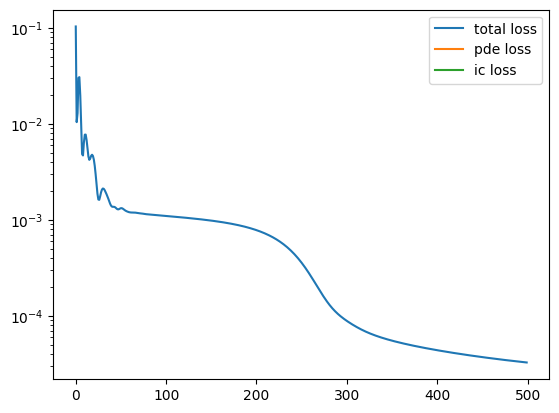

max time: 0.3, min_time 0.29
Epoch 0 - PDE Loss  0.025861 - IC Loss  0.025977 - Total Loss  0.051838
mean u: -8.85993e-05
mean v: 0.0015426122
uv^2: 2.0802132e-05
Epoch 100 - PDE Loss  0.000021 - IC Loss  0.001052 - Total Loss  0.001073
mean u: 0.0759412
mean v: -0.026023425
uv^2: 6.267447e-05
Epoch 200 - PDE Loss  0.000014 - IC Loss  0.000885 - Total Loss  0.000899
mean u: 0.07741965
mean v: -0.026660096
uv^2: 6.615562e-05
Epoch 300 - PDE Loss  0.000021 - IC Loss  0.000204 - Total Loss  0.000225
mean u: 0.08147802
mean v: -0.027157193
uv^2: 9.823607e-05
Epoch 400 - PDE Loss  0.000017 - IC Loss  0.000035 - Total Loss  0.000053
mean u: 0.08306195
mean v: -0.027310446
uv^2: 0.000112144495


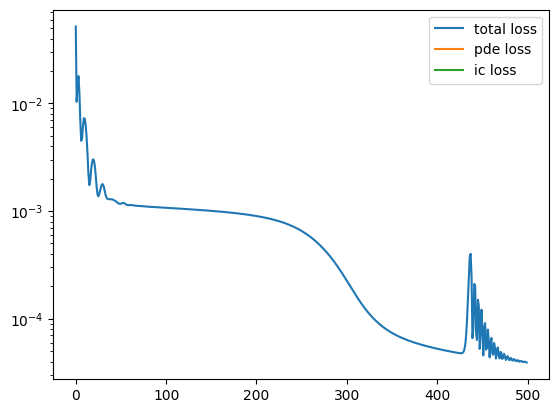

max time: 0.31, min_time 0.3
Epoch 0 - PDE Loss  0.082404 - IC Loss  0.071811 - Total Loss  0.154215
mean u: -0.0016125351
mean v: 0.00042278285
uv^2: -1.9895624e-05
Epoch 100 - PDE Loss  0.000013 - IC Loss  0.000915 - Total Loss  0.000928
mean u: 0.07623391
mean v: -0.02804577
uv^2: 6.775448e-05
Epoch 200 - PDE Loss  0.000016 - IC Loss  0.000679 - Total Loss  0.000695
mean u: 0.06872979
mean v: -0.024507904
uv^2: 4.8927875e-05
Epoch 300 - PDE Loss  0.000024 - IC Loss  0.000078 - Total Loss  0.000102
mean u: 0.07325943
mean v: -0.025100714
uv^2: 8.389394e-05
Epoch 400 - PDE Loss  0.000016 - IC Loss  0.000025 - Total Loss  0.000041
mean u: 0.07203441
mean v: -0.024271522
uv^2: 8.7214336e-05


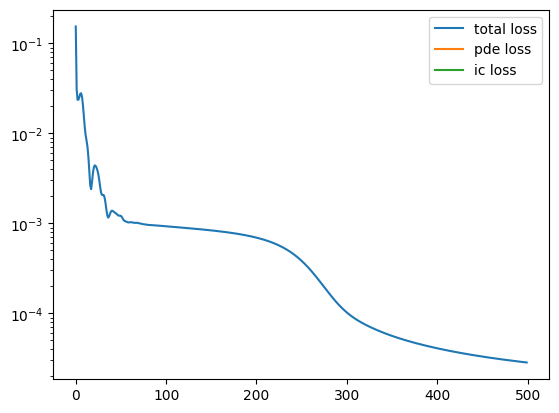

max time: 0.32, min_time 0.31
Epoch 0 - PDE Loss  0.028410 - IC Loss  0.043017 - Total Loss  0.071427
mean u: 0.00030316273
mean v: -0.0013591225
uv^2: 3.4849734e-05
Epoch 100 - PDE Loss  0.000024 - IC Loss  0.000610 - Total Loss  0.000635
mean u: 0.048491884
mean v: -0.016460443
uv^2: 2.7439759e-05
Epoch 200 - PDE Loss  0.000030 - IC Loss  0.000188 - Total Loss  0.000218
mean u: 0.05292868
mean v: -0.018027868
uv^2: 4.8914404e-05
Epoch 300 - PDE Loss  0.000019 - IC Loss  0.000063 - Total Loss  0.000081
mean u: 0.05332762
mean v: -0.017761782
uv^2: 5.8844016e-05
Epoch 400 - PDE Loss  0.000011 - IC Loss  0.000049 - Total Loss  0.000061
mean u: 0.054819252
mean v: -0.018455466
uv^2: 6.0664373e-05


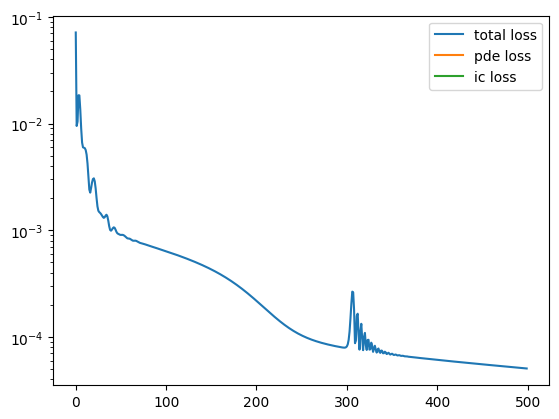

max time: 0.33, min_time 0.32
Epoch 0 - PDE Loss  0.037248 - IC Loss  0.027648 - Total Loss  0.064895
mean u: 0.0011036874
mean v: 0.0010638253
uv^2: 3.9407136e-05
Epoch 100 - PDE Loss  0.000019 - IC Loss  0.000760 - Total Loss  0.000779
mean u: 0.041410506
mean v: -0.015538887
uv^2: 1.7637894e-05
Epoch 200 - PDE Loss  0.000009 - IC Loss  0.000584 - Total Loss  0.000593
mean u: 0.037554212
mean v: -0.013395644
uv^2: 1.5632962e-05
Epoch 300 - PDE Loss  0.000011 - IC Loss  0.000295 - Total Loss  0.000306
mean u: 0.038408186
mean v: -0.013501663
uv^2: 2.1752043e-05
Epoch 400 - PDE Loss  0.000013 - IC Loss  0.000047 - Total Loss  0.000060
mean u: 0.041726287
mean v: -0.014364594
uv^2: 3.8363363e-05


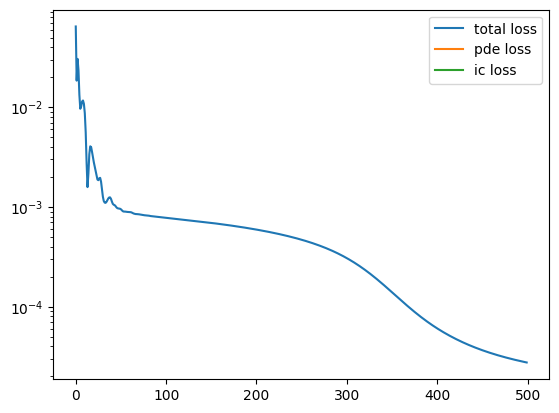

max time: 0.34, min_time 0.33
Epoch 0 - PDE Loss  0.089610 - IC Loss  0.077244 - Total Loss  0.166853
mean u: 0.005547212
mean v: -0.0010955002
uv^2: 0.00010507939
Epoch 100 - PDE Loss  0.000046 - IC Loss  0.000657 - Total Loss  0.000703
mean u: 0.06427772
mean v: -0.029603815
uv^2: 8.3628394e-05
Epoch 200 - PDE Loss  0.000016 - IC Loss  0.000538 - Total Loss  0.000554
mean u: 0.03495195
mean v: -0.015134845
uv^2: 1.6442102e-05
Epoch 300 - PDE Loss  0.000015 - IC Loss  0.000330 - Total Loss  0.000345
mean u: 0.02803097
mean v: -0.010809776
uv^2: 1.3031409e-05
Epoch 400 - PDE Loss  0.000016 - IC Loss  0.000063 - Total Loss  0.000078
mean u: 0.028709713
mean v: -0.010287591
uv^2: 2.302464e-05


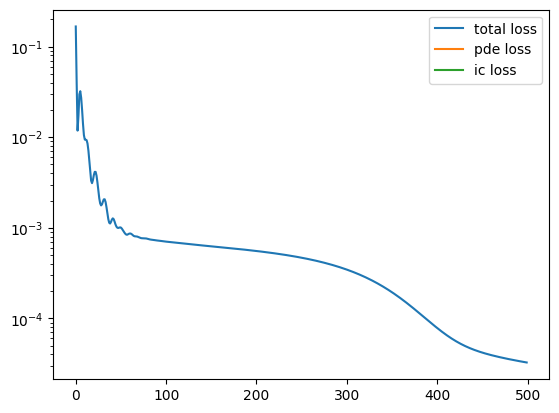

max time: 0.35, min_time 0.34
Epoch 0 - PDE Loss  0.138107 - IC Loss  0.058976 - Total Loss  0.197083
mean u: 0.0019199078
mean v: 0.0037215485
uv^2: 0.0004478817
Epoch 100 - PDE Loss  0.000077 - IC Loss  0.000537 - Total Loss  0.000614
mean u: 0.07150858
mean v: -0.032677118
uv^2: 0.000113575545
Epoch 200 - PDE Loss  0.000029 - IC Loss  0.000408 - Total Loss  0.000438
mean u: 0.036087524
mean v: -0.015756024
uv^2: 2.6669819e-05
Epoch 300 - PDE Loss  0.000017 - IC Loss  0.000218 - Total Loss  0.000235
mean u: 0.025309706
mean v: -0.0095977485
uv^2: 1.7219803e-05
Epoch 400 - PDE Loss  0.000015 - IC Loss  0.000051 - Total Loss  0.000066
mean u: 0.021581698
mean v: -0.0070345243
uv^2: 1.8232702e-05


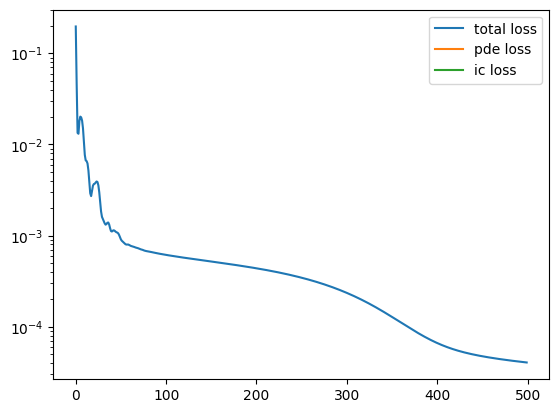

max time: 0.36, min_time 0.35
Epoch 0 - PDE Loss  0.151529 - IC Loss  0.089306 - Total Loss  0.240836
mean u: -0.00023686505
mean v: -0.002290537
uv^2: -0.00016061253
Epoch 100 - PDE Loss  0.000042 - IC Loss  0.000598 - Total Loss  0.000640
mean u: 0.048607297
mean v: -0.024076685
uv^2: 4.4910288e-05
Epoch 200 - PDE Loss  0.000014 - IC Loss  0.000460 - Total Loss  0.000474
mean u: 0.017167991
mean v: -0.007068535
uv^2: 4.5991274e-06
Epoch 300 - PDE Loss  0.000013 - IC Loss  0.000330 - Total Loss  0.000343
mean u: 0.012041746
mean v: -0.0037621413
uv^2: 3.974585e-06
Epoch 400 - PDE Loss  0.000013 - IC Loss  0.000206 - Total Loss  0.000219
mean u: 0.012025089
mean v: -0.0034334655
uv^2: 5.794742e-06


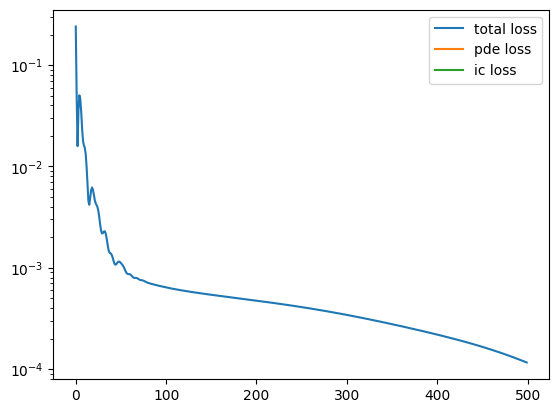

max time: 0.37, min_time 0.36
Epoch 0 - PDE Loss  0.040453 - IC Loss  0.021587 - Total Loss  0.062041
mean u: -0.0016485617
mean v: 5.653019e-05
uv^2: 2.7864055e-05
Epoch 100 - PDE Loss  0.000016 - IC Loss  0.000195 - Total Loss  0.000211
mean u: 0.01148095
mean v: -0.0052647213
uv^2: 4.328757e-06
Epoch 200 - PDE Loss  0.000012 - IC Loss  0.000036 - Total Loss  0.000049
mean u: 0.009198909
mean v: -0.0032701027
uv^2: 4.73054e-06
Epoch 300 - PDE Loss  0.000007 - IC Loss  0.000020 - Total Loss  0.000027
mean u: 0.010472029
mean v: -0.0038848324
uv^2: 5.590485e-06
Epoch 400 - PDE Loss  0.000005 - IC Loss  0.000012 - Total Loss  0.000017
mean u: 0.009931345
mean v: -0.0034239404
uv^2: 5.4088937e-06


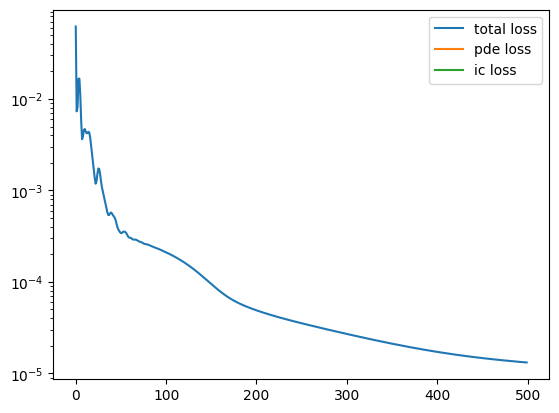

max time: 0.38, min_time 0.37
Epoch 0 - PDE Loss  0.026432 - IC Loss  0.025627 - Total Loss  0.052060
mean u: 0.0005511204
mean v: 0.0013839181
uv^2: 1.6734797e-05
Epoch 100 - PDE Loss  0.000005 - IC Loss  0.000276 - Total Loss  0.000281
mean u: 0.0071137724
mean v: -0.0029630654
uv^2: 1.6742397e-06
Epoch 200 - PDE Loss  0.000003 - IC Loss  0.000242 - Total Loss  0.000245
mean u: 0.0073133665
mean v: -0.0029223093
uv^2: 1.7200423e-06
Epoch 300 - PDE Loss  0.000003 - IC Loss  0.000188 - Total Loss  0.000191
mean u: 0.007225743
mean v: -0.0027270534
uv^2: 1.6930811e-06
Epoch 400 - PDE Loss  0.000005 - IC Loss  0.000087 - Total Loss  0.000093
mean u: 0.0074190176
mean v: -0.0025580071
uv^2: 1.5948315e-06


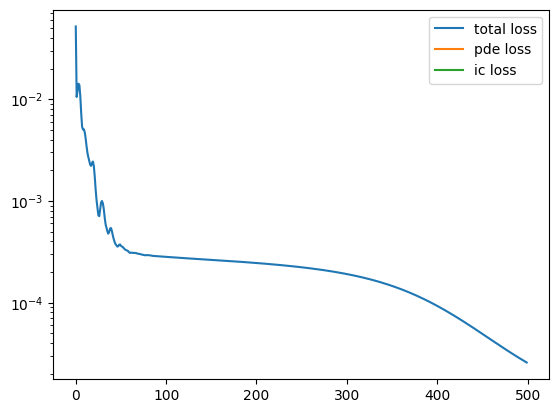

max time: 0.39, min_time 0.38
Epoch 0 - PDE Loss  0.075294 - IC Loss  0.109127 - Total Loss  0.184420
mean u: -0.0007077433
mean v: -0.00039940167
uv^2: -0.00017505679
Epoch 100 - PDE Loss  0.000044 - IC Loss  0.000243 - Total Loss  0.000287
mean u: 0.039737456
mean v: -0.021691725
uv^2: 3.9116287e-05
Epoch 200 - PDE Loss  0.000015 - IC Loss  0.000161 - Total Loss  0.000176
mean u: 0.015319722
mean v: -0.0076361047
uv^2: 5.7640405e-06
Epoch 300 - PDE Loss  0.000010 - IC Loss  0.000096 - Total Loss  0.000106
mean u: 0.008062511
mean v: -0.0029808334
uv^2: 2.1168203e-06
Epoch 400 - PDE Loss  0.000008 - IC Loss  0.000051 - Total Loss  0.000059
mean u: 0.006077204
mean v: -0.0015514895
uv^2: 1.2638345e-06


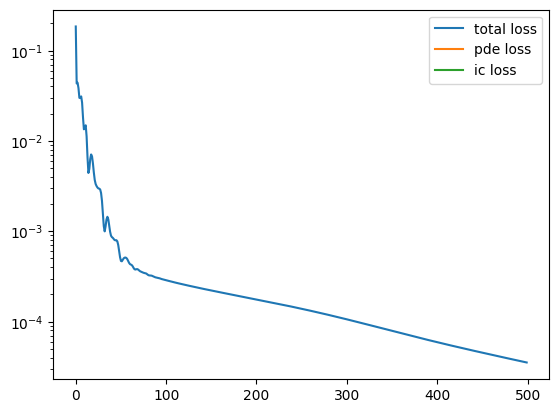

max time: 0.4, min_time 0.39
Epoch 0 - PDE Loss  0.064270 - IC Loss  0.105058 - Total Loss  0.169328
mean u: 0.00201119
mean v: -0.000912965
uv^2: 0.00019507395
Epoch 100 - PDE Loss  0.000030 - IC Loss  0.000179 - Total Loss  0.000210
mean u: 0.028426966
mean v: -0.015181164
uv^2: 1.9063245e-05
Epoch 200 - PDE Loss  0.000010 - IC Loss  0.000143 - Total Loss  0.000153
mean u: 0.009450011
mean v: -0.0048820716
uv^2: 3.0890408e-06
Epoch 300 - PDE Loss  0.000006 - IC Loss  0.000122 - Total Loss  0.000127
mean u: 0.0025025052
mean v: -0.00048141798
uv^2: 4.1017145e-07
Epoch 400 - PDE Loss  0.000004 - IC Loss  0.000102 - Total Loss  0.000106
mean u: 0.0008696125
mean v: 0.000586588
uv^2: -2.1022981e-07


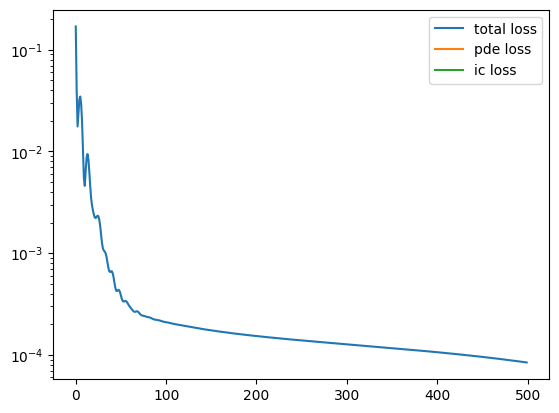

max time: 0.41, min_time 0.4
Epoch 0 - PDE Loss  0.032957 - IC Loss  0.027880 - Total Loss  0.060837
mean u: -0.0009233759
mean v: 0.00029059185
uv^2: -2.3756624e-05
Epoch 100 - PDE Loss  0.000011 - IC Loss  0.000036 - Total Loss  0.000047
mean u: 0.011260989
mean v: -0.0070287134
uv^2: 4.015556e-06
Epoch 200 - PDE Loss  0.000005 - IC Loss  0.000018 - Total Loss  0.000024
mean u: 0.0037580605
mean v: -0.0023067917
uv^2: 1.1464871e-06
Epoch 300 - PDE Loss  0.000004 - IC Loss  0.000012 - Total Loss  0.000016
mean u: 0.002635523
mean v: -0.0014554787
uv^2: 7.4974287e-07
Epoch 400 - PDE Loss  0.000003 - IC Loss  0.000009 - Total Loss  0.000013
mean u: 0.0019665903
mean v: -0.0009399073
uv^2: 4.8240685e-07


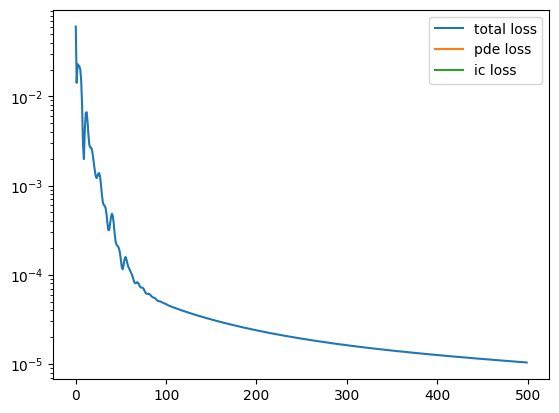

max time: 0.42, min_time 0.41
Epoch 0 - PDE Loss  0.046388 - IC Loss  0.024908 - Total Loss  0.071296
mean u: 0.0017912331
mean v: -0.0003609889
uv^2: 3.643381e-05
Epoch 100 - PDE Loss  0.000026 - IC Loss  0.000023 - Total Loss  0.000048
mean u: 0.023682993
mean v: -0.01396673
uv^2: 1.0674355e-05
Epoch 200 - PDE Loss  0.000009 - IC Loss  0.000008 - Total Loss  0.000017
mean u: 0.0067440094
mean v: -0.0034217034
uv^2: 1.8274218e-06
Epoch 300 - PDE Loss  0.000005 - IC Loss  0.000005 - Total Loss  0.000010
mean u: 0.003179295
mean v: -0.001031534
uv^2: 6.615954e-07
Epoch 400 - PDE Loss  0.000004 - IC Loss  0.000003 - Total Loss  0.000007
mean u: 0.0022330296
mean v: -0.00038118812
uv^2: 3.2020776e-07


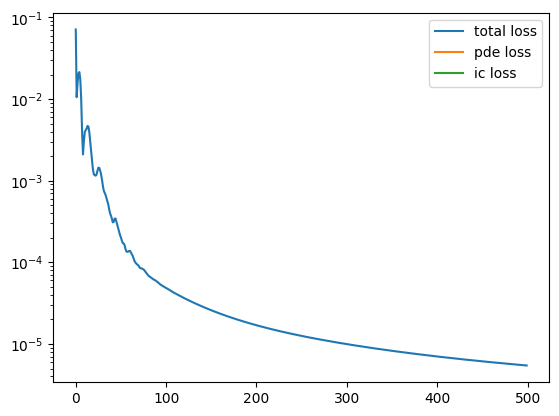

max time: 0.43, min_time 0.42
Epoch 0 - PDE Loss  0.093530 - IC Loss  0.045726 - Total Loss  0.139255
mean u: -0.00043994765
mean v: -0.00088243687
uv^2: 9.702864e-05
Epoch 100 - PDE Loss  0.000012 - IC Loss  0.000029 - Total Loss  0.000041
mean u: -0.00027978694
mean v: 0.00046107307
uv^2: -4.2327335e-07
Epoch 200 - PDE Loss  0.000006 - IC Loss  0.000010 - Total Loss  0.000016
mean u: 0.0021428352
mean v: -0.00092273724
uv^2: 3.360065e-07
Epoch 300 - PDE Loss  0.000004 - IC Loss  0.000005 - Total Loss  0.000009
mean u: 0.0022407249
mean v: -0.0009792371
uv^2: 3.3103697e-07
Epoch 400 - PDE Loss  0.000003 - IC Loss  0.000003 - Total Loss  0.000006
mean u: 0.0022248703
mean v: -0.0009467555
uv^2: 3.0900523e-07


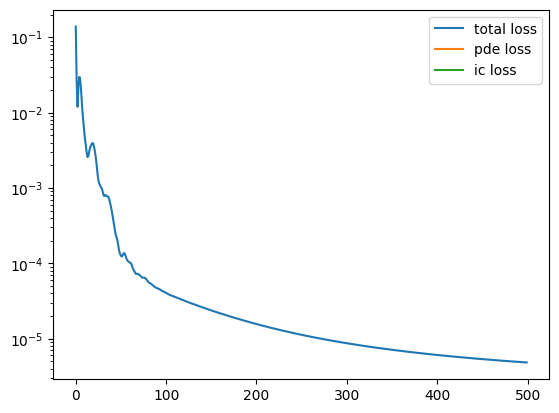

max time: 0.44, min_time 0.43
Epoch 0 - PDE Loss  0.052955 - IC Loss  0.026056 - Total Loss  0.079010
mean u: 0.0022094434
mean v: -0.0019191632
uv^2: 8.634576e-06
Epoch 100 - PDE Loss  0.000009 - IC Loss  0.000018 - Total Loss  0.000027
mean u: 0.0056696488
mean v: -0.0027975002
uv^2: 1.2415047e-06
Epoch 200 - PDE Loss  0.000005 - IC Loss  0.000006 - Total Loss  0.000012
mean u: 0.0033684194
mean v: -0.001305999
uv^2: 4.4750237e-07
Epoch 300 - PDE Loss  0.000004 - IC Loss  0.000004 - Total Loss  0.000008
mean u: 0.0026826167
mean v: -0.0007950235
uv^2: 2.2094241e-07
Epoch 400 - PDE Loss  0.000003 - IC Loss  0.000003 - Total Loss  0.000006
mean u: 0.0020541989
mean v: -0.00034327136
uv^2: 3.985764e-08


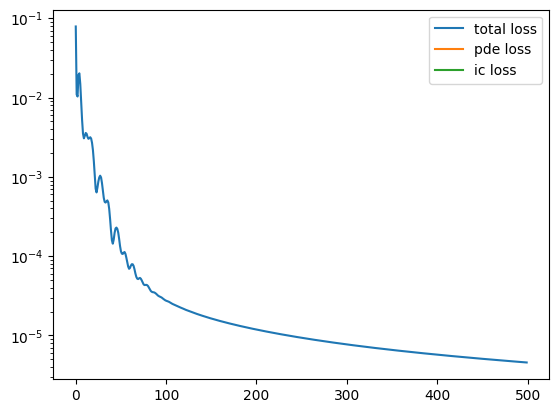

max time: 0.45, min_time 0.44
Epoch 0 - PDE Loss  0.022993 - IC Loss  0.017838 - Total Loss  0.040831
mean u: -0.00014879156
mean v: -0.0007426879
uv^2: -8.713138e-06
Epoch 100 - PDE Loss  0.000013 - IC Loss  0.000018 - Total Loss  0.000032
mean u: 0.009369559
mean v: -0.0057273046
uv^2: 3.2703206e-06
Epoch 200 - PDE Loss  0.000005 - IC Loss  0.000007 - Total Loss  0.000013
mean u: 0.0021211738
mean v: -0.00097090285
uv^2: 4.782637e-07
Epoch 300 - PDE Loss  0.000003 - IC Loss  0.000004 - Total Loss  0.000007
mean u: 0.0015350557
mean v: -0.0005916361
uv^2: 2.956194e-07
Epoch 400 - PDE Loss  0.000002 - IC Loss  0.000002 - Total Loss  0.000005
mean u: 0.0013620916
mean v: -0.00047736196
uv^2: 2.3607849e-07


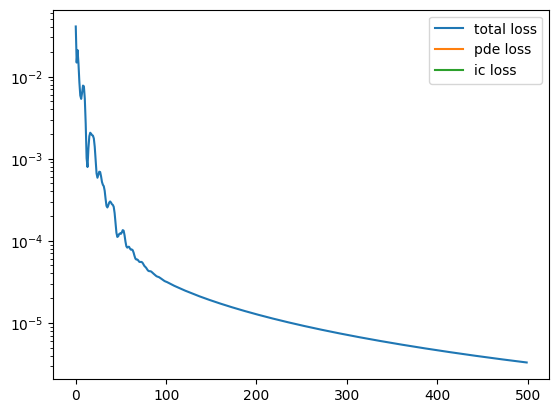

max time: 0.46, min_time 0.45
Epoch 0 - PDE Loss  0.116553 - IC Loss  0.059673 - Total Loss  0.176226
mean u: 0.0023699806
mean v: -0.0013175206
uv^2: 4.7748315e-05
Epoch 100 - PDE Loss  0.000028 - IC Loss  0.000014 - Total Loss  0.000042
mean u: 0.029849973
mean v: -0.017403606
uv^2: 1.9232843e-05
Epoch 200 - PDE Loss  0.000005 - IC Loss  0.000004 - Total Loss  0.000009
mean u: 0.009884409
mean v: -0.0057540857
uv^2: 2.4621022e-06
Epoch 300 - PDE Loss  0.000002 - IC Loss  0.000002 - Total Loss  0.000004
mean u: 0.00522283
mean v: -0.002729636
uv^2: 9.4053485e-07
Epoch 400 - PDE Loss  0.000001 - IC Loss  0.000001 - Total Loss  0.000003
mean u: 0.0037022529
mean v: -0.0016753013
uv^2: 5.376274e-07


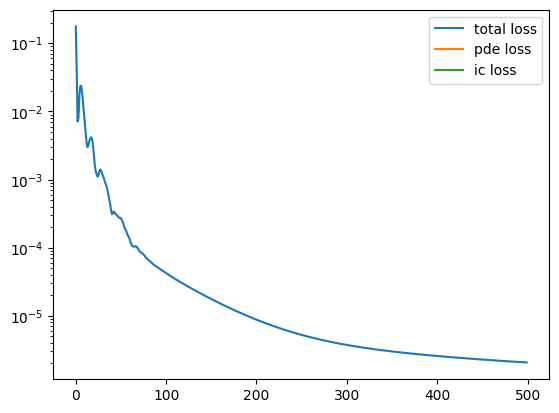

max time: 0.47, min_time 0.46
Epoch 0 - PDE Loss  0.108137 - IC Loss  0.130624 - Total Loss  0.238761
mean u: -0.00023177509
mean v: -0.0013479816
uv^2: 4.8828042e-05
Epoch 100 - PDE Loss  0.000040 - IC Loss  0.000023 - Total Loss  0.000063
mean u: 0.03540523
mean v: -0.019723
uv^2: 2.7970613e-05
Epoch 200 - PDE Loss  0.000011 - IC Loss  0.000010 - Total Loss  0.000021
mean u: 0.014583872
mean v: -0.008467111
uv^2: 3.840583e-06
Epoch 300 - PDE Loss  0.000005 - IC Loss  0.000006 - Total Loss  0.000011
mean u: 0.0067869592
mean v: -0.0036249969
uv^2: 1.1564873e-06
Epoch 400 - PDE Loss  0.000003 - IC Loss  0.000004 - Total Loss  0.000007
mean u: 0.0045816177
mean v: -0.002198659
uv^2: 6.93411e-07


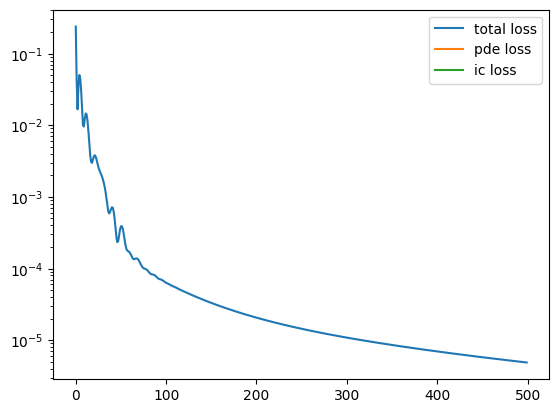

max time: 0.48, min_time 0.47
Epoch 0 - PDE Loss  0.030818 - IC Loss  0.060658 - Total Loss  0.091476
mean u: -0.0002812562
mean v: 0.00048587355
uv^2: -8.999693e-05
Epoch 100 - PDE Loss  0.000014 - IC Loss  0.000016 - Total Loss  0.000030
mean u: 0.009755171
mean v: -0.0047131
uv^2: 1.6402133e-06
Epoch 200 - PDE Loss  0.000008 - IC Loss  0.000009 - Total Loss  0.000017
mean u: 0.0026657535
mean v: -0.0004484555
uv^2: 1.9246198e-07
Epoch 300 - PDE Loss  0.000005 - IC Loss  0.000006 - Total Loss  0.000011
mean u: 0.002508703
mean v: -0.00041314765
uv^2: 1.760541e-07
Epoch 400 - PDE Loss  0.000004 - IC Loss  0.000005 - Total Loss  0.000008
mean u: 0.0025580379
mean v: -0.0004952039
uv^2: 1.9727828e-07


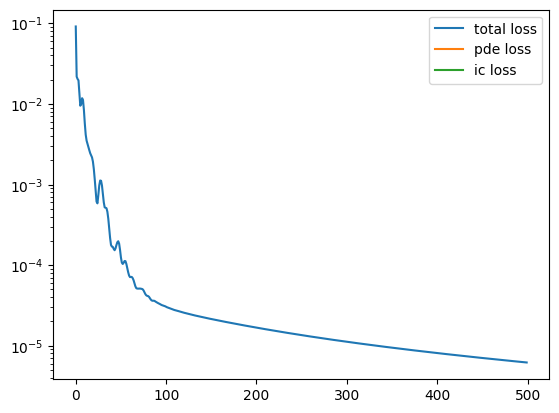

max time: 0.49, min_time 0.48
Epoch 0 - PDE Loss  0.122671 - IC Loss  0.066036 - Total Loss  0.188707
mean u: -0.0004173262
mean v: -0.00045702868
uv^2: 9.67592e-08
Epoch 100 - PDE Loss  0.000068 - IC Loss  0.000014 - Total Loss  0.000082
mean u: 0.04542065
mean v: -0.026684597
uv^2: 4.954189e-05
Epoch 200 - PDE Loss  0.000017 - IC Loss  0.000005 - Total Loss  0.000022
mean u: 0.014221289
mean v: -0.008192387
uv^2: 3.5945866e-06
Epoch 300 - PDE Loss  0.000007 - IC Loss  0.000003 - Total Loss  0.000010
mean u: 0.0048097153
mean v: -0.0019849301
uv^2: 8.1691314e-07
Epoch 400 - PDE Loss  0.000004 - IC Loss  0.000002 - Total Loss  0.000007
mean u: 0.0020932858
mean v: -0.00017460792
uv^2: 2.4610551e-07


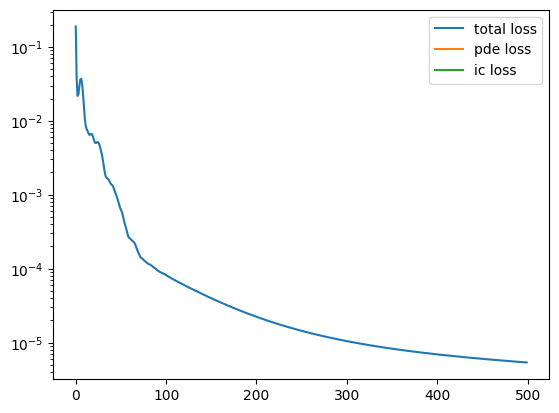

max time: 0.5, min_time 0.49
Epoch 0 - PDE Loss  0.049880 - IC Loss  0.026914 - Total Loss  0.076794
mean u: -0.00050963083
mean v: -0.0024522305
uv^2: -6.1898736e-06
Epoch 100 - PDE Loss  0.000017 - IC Loss  0.000007 - Total Loss  0.000024
mean u: 0.0072349943
mean v: -0.005143356
uv^2: 2.0800487e-06
Epoch 200 - PDE Loss  0.000005 - IC Loss  0.000004 - Total Loss  0.000009
mean u: -0.0018756716
mean v: 0.00060334924
uv^2: -1.9841022e-07
Epoch 300 - PDE Loss  0.000003 - IC Loss  0.000002 - Total Loss  0.000005
mean u: -0.0022756683
mean v: 0.00095424184
uv^2: -2.9947367e-07
Epoch 400 - PDE Loss  0.000002 - IC Loss  0.000002 - Total Loss  0.000004
mean u: -0.0024688975
mean v: 0.001162683
uv^2: -3.567336e-07


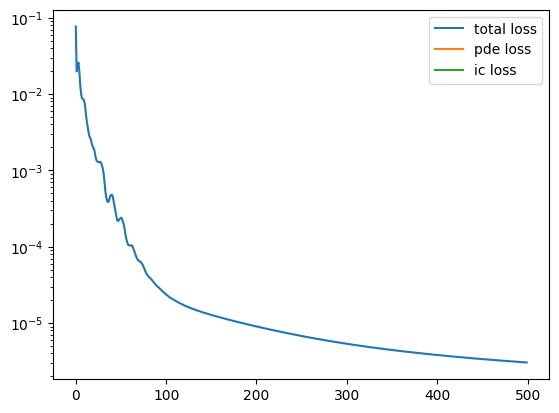

max time: 0.5, min_time 0.0
Epoch 0 - PDE Loss  0.109251 - IC Loss  1.283414 - Total Loss  1.481168
mean u: -0.004125003
mean v: -0.0058273165
uv^2: -0.0002727716
Epoch 100 - PDE Loss  0.032148 - IC Loss  0.774521 - Total Loss  0.893378
mean u: 0.11212908
mean v: -0.027257923
uv^2: 0.0045414297
Epoch 200 - PDE Loss  0.058611 - IC Loss  0.412607 - Total Loss  0.543352
mean u: 0.21874751
mean v: -0.011368928
uv^2: 0.0116880275
Epoch 300 - PDE Loss  0.057717 - IC Loss  0.251632 - Total Loss  0.366483
mean u: 0.23685269
mean v: -0.010222613
uv^2: 0.0128497
Epoch 400 - PDE Loss  0.054664 - IC Loss  0.166552 - Total Loss  0.267568
mean u: 0.23713359
mean v: -0.01495281
uv^2: 0.011757764
Epoch 500 - PDE Loss  0.050935 - IC Loss  0.130789 - Total Loss  0.223205
mean u: 0.23806548
mean v: -0.015057249
uv^2: 0.0110584125
Epoch 600 - PDE Loss  0.040919 - IC Loss  0.116935 - Total Loss  0.195114
mean u: 0.23681614
mean v: -0.014962686
uv^2: 0.010277524
Epoch 700 - PDE Loss  0.050829 - IC Loss  0.0

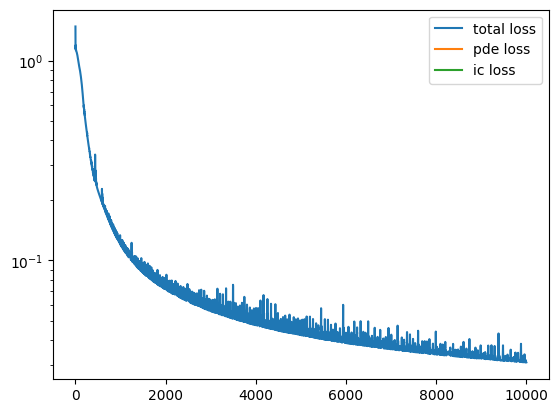

In [57]:
steps = 50
models = []
inits = []
intervals = []
for i in range(1, steps+2):
    epochs = 500
    max_time = i * tmax / steps
    if i == steps + 1:
        max_time = tmax
        min_time = 0.0
        # epochs = 4 * epochs
    elif i == 1:
        min_time = 0.0
    else:
        min_time = ((i-1) * tmax / steps)
    print(f"max time: {max_time}, min_time {min_time}")
    intervals.append((min_time, max_time))
    pde_pts, ic_pts = generatePoints(N_inputs, sphere, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=min_time, tmax=max_time)
    if i > 1 and i != steps+1:
        xi, yi, zi = ic_pts[0][:,0:1], ic_pts[0][:,1:2], ic_pts[0][:,2:3]
        ti = tf.ones_like(x) * min_time
        ui = models[i-2]([xi, yi, zi, ti])
        ic_pts = [tf.concat([xi, yi, zi, ti], axis=1), ui]
    x, y, z, t = pde_pts[:,0:1], pde_pts[:,1:2], pde_pts[:,2:3], pde_pts[:,3:4]
    normals =  tf.convert_to_tensor(normalVector(pde_pts[:,0:3]), dtype=tf.float32)
    normal_jacobian = tf.convert_to_tensor(compute_normal_jacobian(pde_pts[:,0:3].numpy(), normals.numpy()), dtype=tf.float32)
    # init = tf.concat(initial(x, y, z), axis=-1)
    if i != steps+1:
        init = build_init(i, models, x, y, z, intervals)
        # if i == 1:
        #     init = initial(x, y, z)
        #     init = tf.concat(init, axis=-1)
        #     inits.append(init)
        
        # elif i != 1:
        #     init = hardConstraint(model, x, y, z, tf.ones_like(x) * min_time, i, models, inits, intervals, min_time, max_time)
        #     inits.append(init)

        @tf.function(reduce_retracing=True)
        def ts(model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, lambda_pde=1.0, lambda_ic=1.0, alpha=0.0): 
            return trainingStep(model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, lambda_pde=1.0, lambda_ic=1.0, alpha=0.0)
        all_pts = tf.concat([pde_pts, ic_pts[0]], axis=0) # use this one for soft constraints
        pmin = tf.reduce_min(all_pts, axis=0)
        pmax = tf.reduce_max(all_pts, axis=0)
        model = buildModel(width, depth, pmin, pmax)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        losses, pde_losses, ic_losses, l2s, grads, uv2 = train(ts, model, optimizer, pde_pts, ic_pts, i, init, models, intervals, min_time, max_time, normals, normal_jacobian, epochs=epochs)

    else:
        init = initial(x, y, z)
        init = tf.concat(init, axis=-1)   
        inits.append(init)
        inits_j = []  
        intervals_j = []


        all_pts = tf.concat([pde_pts, ic_pts[0]], axis=0) # use this one for soft constraints
        pmin = tf.reduce_min(all_pts, axis=0)
        pmax = tf.reduce_max(all_pts, axis=0)
        model = buildModel(width, depth, pmin, pmax)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        def helper_hc(model, x, y, z, t, init, tmin=tmin, tmax=tmax):
            x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
            nn = model([x, y, z, t])

            # uv0 = tf.concat(initial(x,y,z), axis=-1)
            uv0 = init

            u = uv0 + (t - tmin) / (tmax - tmin) * nn
            # u = initial(x, y, z, radii) + nn

            return u
        
        normals = normalVector(pde_pts[:,0:3])
        normal_jacobian = tf.convert_to_tensor(compute_normal_jacobian(pde_pts[:,0:3].numpy(), normals), dtype=tf.float32)

        data = prediction(x, y, z, t, models, intervals)

        losses, pde_losses, ic_losses, l2s, grads, uv2 = train(final_training_step, model, optimizer, pde_pts, ic_pts, 0, init, models, intervals, min_time, max_time, normals, normal_jacobian, final=True, data=data, epochs=10000)

    models.append(model)

# if i % 25 == 0:
#     model.save_weights('fitz_hugh_sphere.weights.h5')
#     print('Saved weights!')
# if i == steps:
#     model.save_weights('fitz_hugh_sphere.weights.h5')
#     print('Saved weights and finished training!')        
    losses = [l.numpy() for l in losses]
    pde_losses = [l.numpy() for l in pde_losses]
    ic_losses = [l.numpy() for l in ic_losses]
    plt.plot(losses, label='total loss')
    plt.plot(pde_losses, label='pde loss')
    plt.plot(ic_losses, label='ic loss')
    plt.legend()
    plt.yscale('log')
    plt.show()

In [58]:
# losses, pde_losses, ic_losses, l2s, grads, uv2 = train(model, optimizer, pde_pts, ic_pts, u_sc, v_sc, radii, normals, normal_jacobian, epochs=5000)
# losses = [l.numpy() for l in losses]
# pde_losses = [l.numpy() for l in pde_losses]
# ic_losses = [l.numpy() for l in ic_losses]
# uv2s = [l for l in uv2]

In [59]:
# model.save_weights('sphere_gs.weights.h5')

In [60]:
# plt.plot(losses, label='total loss')
# plt.plot(pde_losses, label='pde loss')
# plt.plot(ic_losses, label='ic loss')
# plt.legend()
# # plt.xscale('log')
# plt.yscale('log')

In [61]:
# plt.plot(uv2s)
# plt.yscale('log')

In [62]:
print(tf.random.normal((1,)))

tf.Tensor([0.7915615], shape=(1,), dtype=float32)


In [63]:
def set_axes_equal_tensorflow(ax, x, y, z):
    x = tf.reshape(x, [-1]).numpy()
    y = tf.reshape(y, [-1]).numpy()
    z = tf.reshape(z, [-1]).numpy()

    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    z_min, z_max = z.min(), z.max()

    x_range = x_max - x_min
    y_range = y_max - y_min
    z_range = z_max - z_min

    max_range = max(x_range, y_range, z_range)

    x_middle = 0.5 * (x_max + x_min)
    y_middle = 0.5 * (y_max + y_min)
    z_middle = 0.5 * (z_max + z_min)

    ax.set_xlim([x_middle - max_range/2, x_middle + max_range/2])
    ax.set_ylim([y_middle - max_range/2, y_middle + max_range/2])

In [64]:
def modelResults(model, surface, umin=0.0, umax=1.0, vmin=-np.pi/2, vmax=1.0, t_steps=3, tmax=tmax, resolution=100, load=False, saveplots=False):
  if load:
    model.load_weights(load)

  test_pde_pts, _ = generatePoints(resolution, sphere, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=tmin, tmax=tmax)

  x, y, z = test_pde_pts[:,0:1], test_pde_pts[:,1:2], test_pde_pts[:,2:3]

  # norm_actual, norm_pred, colors_actual, colors_pred = None, None, None, None
  init = tf.concat(initial(x, y, z), axis=-1)

  u_norm_pred = None
  v_norm_pred = None

  for i in range(t_steps+1):
    t = tf.ones_like(x) * (i * tmax / t_steps)
    pde_pts = tf.stack([x, y, z, t], axis=1)

    x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)

    print(f"t={i * tmax / t_steps}")
    u_pred = tf.reshape(final_hard_constraint(models[-1], x, y, z, t, tmin=tmin, tmax=tmax)[:,0], x.shape).numpy()
    # u_pred = tf.reshape(prediction(x, y, z, t, models, intervals)[:,0], x.shape).numpy()
    if i == i: 
      u_norm_pred = plt.Normalize(vmin=u_pred.min(), vmax=u_pred.max())

    X = x.numpy().ravel()
    Y = y.numpy().ravel()
    Z = z.numpy().ravel()
  
    UP = u_pred.ravel()             

    fig = plt.figure(figsize=(18, 6))

    ax2    = fig.add_subplot(121, projection='3d')

    ax2.set_box_aspect([1, 1, 1])

    u_sc_pred = ax2.scatter(
        X, Y, Z,
        c=UP,
        cmap='rainbow',
        norm=u_norm_pred,
        marker='o'
    )

    fig.colorbar(u_sc_pred, ax=ax2,  shrink=0.6)

    set_axes_equal_tensorflow(ax2,    x, y, z)

    ax2.view_init(elev=15, azim=220)

    v_pred = tf.reshape(final_hard_constraint(models[-1], x, y, z, t, tmin=tmin, tmax=tmax)[:,1], x.shape).numpy()
    # v_pred = tf.reshape(prediction(x, y, z, t, models, intervals)[:,1], x.shape).numpy()

    if i == i:
      v_norm_pred = plt.Normalize(vmin=v_pred.min(), vmax=v_pred.max())

    X = x.numpy().ravel()
    Y = y.numpy().ravel()
    Z = z.numpy().ravel()

    VP = v_pred.ravel()             

    ax3 = fig.add_subplot(122, projection='3d')

    ax3.set_box_aspect([1, 1, 1])

    v_sc_pred = ax3.scatter(
        X, Y, Z,
        c=VP,
        cmap='rainbow',
        norm=v_norm_pred,
        marker='o'
    )

    fig.colorbar(v_sc_pred, ax=ax3, shrink=0.6)

    set_axes_equal_tensorflow(ax3, x, y, z)

    ax3.view_init(elev=15, azim=220)

    plt.show()



  if saveplots:
    plt.savefig(f'{surface.__name__}_results.png')
  plt.show()

In [65]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def modelResults(model, surface, umin=0.0, umax=1.0, vmin=-np.pi/2, vmax=1.0, t_steps=3, tmax=tmax, resolution=100, load=False, saveplots=False):
    if load:
        model.load_weights(load)
    test_pde_pts, _ = generatePoints(resolution, sphere, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=tmin, tmax=tmax)
    x, y, z = test_pde_pts[:,0:1], test_pde_pts[:,1:2], test_pde_pts[:,2:3]
    # norm_actual, norm_pred, colors_actual, colors_pred = None, None, None, None
    init = tf.concat(initial(x, y, z), axis=-1)
    u_norm_pred = None
    v_norm_pred = None
    
    for i in range(t_steps+1):
        t = tf.ones_like(x) * (i * tmax / t_steps)
        pde_pts = tf.stack([x, y, z, t], axis=1)
        x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)
        print(f"t={i * tmax / t_steps}")
        
        u_pred = tf.reshape(final_hard_constraint(models[-1], x, y, z, t, tmin=tmin, tmax=tmax)[:,0], x.shape).numpy()
        # u_pred = tf.reshape(prediction(x, y, z, t, models, intervals)[:,0], x.shape).numpy()
        
        if i == i:
            u_norm_pred = (u_pred.min(), u_pred.max())
            
        X = x.numpy().ravel()
        Y = y.numpy().ravel()
        Z = z.numpy().ravel()
        UP = u_pred.ravel()
        
        # Create subplot figure
        fig = make_subplots(
            rows=1, cols=2,
            subplot_titles=('U Prediction', 'V Prediction'),
            specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]]
        )
        
        # U prediction scatter plot
        fig.add_trace(
            go.Scatter3d(
                x=X, y=Y, z=Z,
                mode='markers',
                marker=dict(
                    size=3,
                    color=UP,
                    colorscale='rainbow',
                    cmin=u_norm_pred[0],
                    cmax=u_norm_pred[1],
                    colorbar=dict(
                        x=0.45,
                        len=0.6,
                        title="U Value"
                    )
                ),
                name='U'
            ),
            row=1, col=1
        )
        
        v_pred = tf.reshape(final_hard_constraint(models[-1], x, y, z, t, tmin=tmin, tmax=tmax)[:,1], x.shape).numpy()
        # v_pred = tf.reshape(prediction(x, y, z, t, models, intervals)[:,1], x.shape).numpy()
        
        if i == i:
            v_norm_pred = (v_pred.min(), v_pred.max())
            
        VP = v_pred.ravel()
        
        # V prediction scatter plot
        fig.add_trace(
            go.Scatter3d(
                x=X, y=Y, z=Z,
                mode='markers',
                marker=dict(
                    size=3,
                    color=VP,
                    colorscale='rainbow',
                    cmin=v_norm_pred[0],
                    cmax=v_norm_pred[1],
                    colorbar=dict(
                        x=1.0,
                        len=0.6,
                        title="V Value"
                    )
                ),
                name='V'
            ),
            row=1, col=2
        )
        
        # Update layout for better visualization
        fig.update_layout(
            scene=dict(
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=0.5)
                ),
                aspectmode='cube'
            ),
            scene2=dict(
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=0.5)
                ),
                aspectmode='cube'
            ),
            width=1200,
            height=500,
            title=f"Model Results at t={i * tmax / t_steps}"
        )
        
        fig.show()
        
        if saveplots:
            fig.write_html(f'{surface.__name__}_results_t{i}.html')
            fig.write_image(f'{surface.__name__}_results_t{i}.png')

In [66]:
modelResults(model, sphere, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, t_steps=9, tmax=tmax, resolution=10000, load=False, saveplots=False)

t=0.0


t=0.05555555555555555


t=0.1111111111111111


t=0.16666666666666666


t=0.2222222222222222


t=0.2777777777777778


t=0.3333333333333333


t=0.3888888888888889


t=0.4444444444444444


t=0.5


In [67]:
# model.save_weights('fitz_hugh_10.weights.h5')

In [68]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import numpy as np
# import tensorflow as tf

# def modelResultsAnimated(model, surface, umin=0.0, umax=1.0, vmin=-np.pi/2, vmax=1.0, 
#                         t_steps=30, tmax=tmax, resolution=100, load=False, 
#                         save_animation=False, animation_filename='model_animation.mp4'):
#     """
#     Create an animated visualization of model results over time steps.
    
#     Parameters:
#     -----------
#     save_animation : bool
#         Whether to save the animation as a video file
#     animation_filename : str
#         Filename for saved animation (supports .mp4, .gif, etc.)
#     """
    
#     if load:
#         model.load_weights(load)
    
#     # Generate test points
#     test_pde_pts, _ = generatePoints(resolution, sphere, umin=0.0, umax=2*np.pi, 
#                                    vmin=-np.pi/2, vmax=np.pi/2, tmin=tmin, tmax=tmax)
#     x, y, z = test_pde_pts[:,0:1], test_pde_pts[:,1:2], test_pde_pts[:,2:3]
    
#     # Pre-compute all predictions for smooth animation
#     print("Pre-computing predictions for all time steps...")
#     all_u_pred = []
#     all_v_pred = []
#     time_values = []
    
#     for i in range(t_steps + 1):
#         t_val = i * tmax / t_steps
#         t = tf.ones_like(x) * t_val
#         x_sq, y_sq, z_sq, t_sq = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)
        
#         u_pred = tf.reshape(final_hard_constraint(models[-1], x_sq, y_sq, z_sq, t_sq, 
#                                                 tmin=tmin, tmax=tmax)[:,0], x_sq.shape).numpy()
#         v_pred = tf.reshape(final_hard_constraint(models[-1], x_sq, y_sq, z_sq, t_sq, 
#                                                 tmin=tmin, tmax=tmax)[:,1], x_sq.shape).numpy()
        
#         all_u_pred.append(u_pred.ravel())
#         all_v_pred.append(v_pred.ravel())
#         time_values.append(t_val)
#         print(f"Computed t={t_val:.3f}")
    
#     # Convert to numpy arrays for easier indexing
#     all_u_pred = np.array(all_u_pred)
#     all_v_pred = np.array(all_v_pred)
    
#     # Set up normalization for consistent color scaling across time steps
#     u_norm = plt.Normalize(vmin=all_u_pred.min(), vmax=all_u_pred.max())
#     v_norm = plt.Normalize(vmin=all_v_pred.min(), vmax=all_v_pred.max())
    
#     # Prepare coordinate arrays
#     X = x.numpy().ravel()
#     Y = y.numpy().ravel()
#     Z = z.numpy().ravel()
    
#     # Set up the figure and 3D axes
#     fig = plt.figure(figsize=(18, 8))
#     ax1 = fig.add_subplot(121, projection='3d')
#     ax2 = fig.add_subplot(122, projection='3d')
    
#     # Set up both axes
#     for ax, title in zip([ax1, ax2], ['U Prediction', 'V Prediction']):
#         ax.set_box_aspect([1, 1, 1])
#         set_axes_equal_tensorflow(ax, x, y, z)
#         ax.view_init(elev=15, azim=220)
#         ax.set_title(title, fontsize=14, pad=20)
    
#     # Initialize scatter plots
#     u_scatter = ax1.scatter(X, Y, Z, c=all_u_pred[0], cmap='rainbow', 
#                            norm=u_norm, marker='o', s=20)
#     v_scatter = ax2.scatter(X, Y, Z, c=all_v_pred[0], cmap='rainbow', 
#                            norm=v_norm, marker='o', s=20)
    
#     # Add colorbars
#     u_cbar = fig.colorbar(u_scatter, ax=ax1, shrink=0.6)
#     v_cbar = fig.colorbar(v_scatter, ax=ax2, shrink=0.6)
    
#     # Add time display
#     time_text = fig.suptitle(f'Time: {time_values[0]:.3f}', fontsize=16)
    
#     def update_frame(frame):
#         """Update function for animation"""
#         # Update scatter plot colors
#         u_scatter.set_array(all_u_pred[frame])
#         v_scatter.set_array(all_v_pred[frame])
        
#         # Update time display
#         time_text.set_text(f'Time: {time_values[frame]:.3f}')
        
#         return u_scatter, v_scatter, time_text
    
#     # Create animation
#     print("Creating animation...")
#     anim = animation.FuncAnimation(fig, update_frame, frames=len(time_values), 
#                                  interval=200, blit=False, repeat=True)
    
#     # Save animation if requested
#     if save_animation:
#         print(f"Saving animation as {animation_filename}...")
#         if animation_filename.endswith('.gif'):
#             anim.save(animation_filename, writer='pillow', fps=5)
#         else:
#             anim.save(animation_filename, writer='ffmpeg', fps=5)
#         print("Animation saved!")
    
#     # Display the animation
#     plt.tight_layout()
#     plt.show()
    
#     return anim  # Return animation object to keep it alive


# # Alternative version with more advanced features
# def modelResultsAnimatedAdvanced(model, surface, umin=0.0, umax=1.0, vmin=-np.pi/2, vmax=1.0, 
#                                t_steps=30, tmax=tmax, resolution=100, load=False, 
#                                save_animation=False, animation_filename='model_animation.mp4',
#                                show_trajectory=False, fps=10):
#     """
#     Advanced animated visualization with additional features.
    
#     Parameters:
#     -----------
#     show_trajectory : bool
#         Whether to show particle trajectories over time
#     fps : int
#         Frames per second for the animation
#     """
    
#     if load:
#         model.load_weights(load)
    
#     test_pde_pts, _ = generatePoints(resolution, sphere, umin=0.0, umax=2*np.pi, 
#                                    vmin=-np.pi/2, vmax=np.pi/2, tmin=tmin, tmax=tmax)
#     x, y, z = test_pde_pts[:,0:1], test_pde_pts[:,1:2], test_pde_pts[:,2:3]
    
#     # Pre-compute predictions
#     print("Pre-computing predictions...")
#     all_u_pred = []
#     all_v_pred = []
#     time_values = []
    
#     for i in range(t_steps + 1):
#         t_val = i * tmax / t_steps
#         t = tf.ones_like(x) * t_val
#         x_sq, y_sq, z_sq, t_sq = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)
        
#         u_pred = tf.reshape(final_hard_constraint(models[-1], x_sq, y_sq, z_sq, t_sq, 
#                                                 tmin=tmin, tmax=tmax)[:,0], x_sq.shape).numpy()
#         v_pred = tf.reshape(final_hard_constraint(models[-1], x_sq, y_sq, z_sq, t_sq, 
#                                                 tmin=tmin, tmax=tmax)[:,1], x_sq.shape).numpy()
        
#         all_u_pred.append(u_pred.ravel())
#         all_v_pred.append(v_pred.ravel())
#         time_values.append(t_val)
    
#     all_u_pred = np.array(all_u_pred)
#     all_v_pred = np.array(all_v_pred)
    
#     # Set up figure with subplots
#     fig = plt.figure(figsize=(20, 10))
    
#     # Main 3D plots
#     ax1 = fig.add_subplot(221, projection='3d')
#     ax2 = fig.add_subplot(222, projection='3d')
    
#     # Time series plots
#     ax3 = fig.add_subplot(223)
#     ax4 = fig.add_subplot(224)
    
#     # Configure 3D axes
#     X = x.numpy().ravel()
#     Y = y.numpy().ravel()
#     Z = z.numpy().ravel()
    
#     u_norm = plt.Normalize(vmin=all_u_pred.min(), vmax=all_u_pred.max())
#     v_norm = plt.Normalize(vmin=all_v_pred.min(), vmax=all_v_pred.max())
    
#     for ax, title in zip([ax1, ax2], ['U Prediction', 'V Prediction']):
#         ax.set_box_aspect([1, 1, 1])
#         set_axes_equal_tensorflow(ax, x, y, z)
#         ax.view_init(elev=15, azim=220)
#         ax.set_title(title)
    
#     # Initialize plots
#     u_scatter = ax1.scatter(X, Y, Z, c=all_u_pred[0], cmap='rainbow', norm=u_norm, s=20)
#     v_scatter = ax2.scatter(X, Y, Z, c=all_v_pred[0], cmap='rainbow', norm=v_norm, s=20)
    
#     fig.colorbar(u_scatter, ax=ax1, shrink=0.6)
#     fig.colorbar(v_scatter, ax=ax2, shrink=0.6)
    
#     # Set up time series plots
#     ax3.set_title('U Statistics Over Time')
#     ax3.set_xlabel('Time')
#     ax3.set_ylabel('U Value')
#     ax4.set_title('V Statistics Over Time')
#     ax4.set_xlabel('Time')
#     ax4.set_ylabel('V Value')
    
#     # Initialize time series data
#     u_means = np.mean(all_u_pred, axis=1)
#     u_mins = np.min(all_u_pred, axis=1)
#     u_maxs = np.max(all_u_pred, axis=1)
#     v_means = np.mean(all_v_pred, axis=1)
#     v_mins = np.min(all_v_pred, axis=1)
#     v_maxs = np.max(all_v_pred, axis=1)
    
#     # Plot full time series (faded)
#     ax3.plot(time_values, u_means, 'b-', alpha=0.3, label='Mean')
#     ax3.fill_between(time_values, u_mins, u_maxs, alpha=0.1, color='blue')
#     ax4.plot(time_values, v_means, 'r-', alpha=0.3, label='Mean')
#     ax4.fill_between(time_values, v_mins, v_maxs, alpha=0.1, color='red')
    
#     # Current time indicators
#     u_line = ax3.axvline(time_values[0], color='blue', linewidth=2)
#     v_line = ax4.axvline(time_values[0], color='red', linewidth=2)
    
#     ax3.legend()
#     ax4.legend()
    
#     time_text = fig.suptitle(f'Time: {time_values[0]:.3f}', fontsize=16)
    
#     def update_frame(frame):
#         # Update scatter plots
#         u_scatter.set_array(all_u_pred[frame])
#         v_scatter.set_array(all_v_pred[frame])
        
#         # Update time indicators
#         u_line.set_xdata([time_values[frame], time_values[frame]])
#         v_line.set_xdata([time_values[frame], time_values[frame]])
        
#         # Update time display
#         time_text.set_text(f'Time: {time_values[frame]:.3f}')
        
#         return u_scatter, v_scatter, u_line, v_line, time_text
    
#     # Create animation
#     anim = animation.FuncAnimation(fig, update_frame, frames=len(time_values), 
#                                  interval=1000//fps, blit=False, repeat=True)
    
#     if save_animation:
#         print(f"Saving animation as {animation_filename}...")
#         if animation_filename.endswith('.gif'):
#             anim.save(animation_filename, writer='pillow', fps=fps)
#         else:
#             anim.save(animation_filename, writer='ffmpeg', fps=fps)
    
#     plt.tight_layout()
#     plt.show()
    
#     return anim


# # Usage examples:
# """
# # Basic animation
# anim = modelResultsAnimated(model, surface, t_steps=50, save_animation=True, 
#                            animation_filename='basic_animation.mp4')

# # Advanced animation with time series
# anim = modelResultsAnimatedAdvanced(model, surface, t_steps=50, fps=15,
#                                    save_animation=True, 
#                                    animation_filename='advanced_animation.mp4')
# """
# anim = modelResultsAnimated(model, sphere, t_steps=50, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, resolution=200000, save_animation=True, 
#                            animation_filename='basic_animation.gif')